# Sieci neuronowe

## Wstęp

Celem laboratorium jest zapoznanie się z podstawami sieci neuronowych oraz uczeniem głębokim (*deep learning*). Zapoznasz się na nim z następującymi tematami:
- treningiem prostych sieci neuronowych, w szczególności z:
  - regresją liniową w sieciach neuronowych
  - optymalizacją funkcji kosztu
  - algorytmem spadku wzdłuż gradientu
  - siecią typu Multilayer Perceptron (MLP)
- frameworkiem PyTorch, w szczególności z:
  - ładowaniem danych
  - preprocessingiem danych
  - pisaniem pętli treningowej i walidacyjnej
  - walidacją modeli
- architekturą i hiperaprametrami sieci MLP, w szczególności z:
  - warstwami gęstymi (w pełni połączonymi)
  - funkcjami aktywacji
  - regularyzacją: L2, dropout

## Wykorzystywane biblioteki

Zaczniemy od pisania ręcznie prostych sieci w bibliotece Numpy, służącej do obliczeń numerycznych na CPU. Później przejdziemy do wykorzystywania frameworka PyTorch, służącego do obliczeń numerycznych na CPU, GPU oraz automatycznego różniczkowania, wykorzystywanego głównie do treningu sieci neuronowych.

Wykorzystamy PyTorcha ze względu na popularność, łatwość instalacji i użycia, oraz dużą kontrolę nad niskopoziomowymi aspektami budowy i treningu sieci neuronowych. Framework ten został stworzony do zastosowań badawczych i naukowych, ale ze względu na wygodę użycia stał się bardzo popularny także w przemyśle. W szczególności całkowicie zdominował przetwarzanie języka naturalnego (NLP) oraz uczenie na grafach.

Pierwszy duży framework do deep learningu, oraz obecnie najpopularniejszy, to TensorFlow, wraz z wysokopoziomową nakładką Keras. Są jednak szanse, że Google (autorzy) będzie go powoli porzucać na rzecz ich nowego frameworka JAX ([dyskusja](https://www.reddit.com/r/MachineLearning/comments/vfl57t/d_google_quietly_moving_its_products_from/), [artykuł Business Insidera](https://www.businessinsider.com/facebook-pytorch-beat-google-tensorflow-jax-meta-ai-2022-6?IR=T)), który jest bardzo świeżym, ale ciekawym narzędziem.

Trzecia, ale znacznie mniej popularna od powyższych opcja to Apache MXNet.

## Konfiguracja własnego komputera

Jeżeli korzystasz z własnego komputera, to musisz zainstalować trochę więcej bibliotek (Google Colab ma je już zainstalowane).

Jeżeli nie masz GPU lub nie chcesz z niego korzystać, to wystarczy znaleźć odpowiednią komendę CPU [na stronie PyTorcha](https://pytorch.org/get-started/locally/). Dla Anacondy odpowiednia komenda została podana poniżej, dla pip'a znajdź ją na stronie.

Jeżeli chcesz korzystać ze wsparcia GPU (na tym laboratorium nie będzie potrzebne, na kolejnych może przyspieszyć nieco obliczenia), to musi być to odpowiednio nowa karta NVidii, mająca CUDA compatibility ([lista](https://developer.nvidia.com/cuda-gpus)). Poza PyTorchem będzie potrzebne narzędzie NVidia CUDA w wersji 11.6 lub 11.7. Instalacja na Windowsie jest bardzo prosta (wystarczy ściągnąć plik EXE i zainstalować jak każdy inny program). Instalacja na Linuxie jest trudna i można względnie łatwo zepsuć sobie system, ale jeżeli chcesz spróbować, to [ten tutorial](https://www.youtube.com/results?search_query=nvidia+cuda+install+ubuntu+20.04) jest bardzo dobry.

In [ ]:
# for conda users
!conda install -y matplotlib pandas pytorch torchvision -c pytorch -c conda-forge

## Wprowadzenie

Zanim zaczniemy naszą przygodę z sieciami neuronowymi, przyjrzyjmy się prostemu przykładowi regresji liniowej na syntetycznych danych:

In [1]:
from typing import Tuple, Dict

import numpy as np
import matplotlib.pyplot as plt

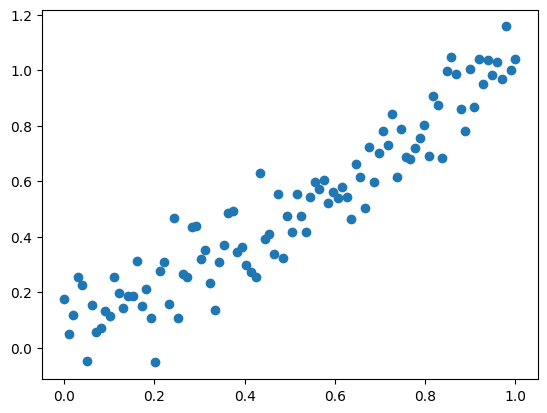

In [2]:
np.random.seed(0)

x = np.linspace(0, 1, 100)
y = x + np.random.normal(scale=0.1, size=x.shape)

plt.scatter(x, y)

W przeciwieństwie do laboratorium 1, tym razem będziemy chcieli rozwiązać ten problem własnoręcznie, bez użycia wysokopoziomowego interfejsu Scikit-learn'a. W tym celu musimy sobie przypomnieć sformułowanie naszego **problemu optymalizacyjnego (optimization problem)**.

W przypadku prostej regresji liniowej (1 zmienna) mamy model postaci $\hat{y} = \alpha x + \beta$, z dwoma parametrami, których będziemy się uczyć. Miarą niedopasowania modelu o danych parametrach jest **funkcja kosztu (cost function)**, nazywana też funkcją celu. Najczęściej używa się **błędu średniokwadratowego (mean squared error, MSE)**:
$$\large
MSE = \frac{1}{N} \sum_{i}^{N} (y - \hat{y})^2
$$

Od jakich $\alpha$ i $\beta$ zacząć? W najprostszym wypadku wystarczy po prostu je wylosować jako niewielkie liczby zmiennoprzecinkowe.

#### Zadanie 1 (0.5 punkt)

Uzupełnij kod funkcji `mse`, obliczającej błąd średniokwadratowy. Wykorzystaj Numpy'a w celu wektoryzacji obliczeń dla wydajności.

In [3]:
def mse(y: np.ndarray, y_hat: np.ndarray) -> float:
    assert y.shape == y_hat.shape, "Kształty tablic y i y_hat muszą być takie same."

    mse_value = np.mean((y - y_hat)**2)

    return mse_value


MSE: 0.133


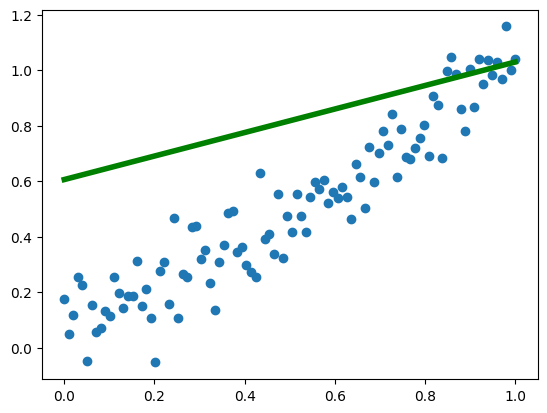

In [4]:
a = np.random.rand()
b = np.random.rand()
print(f"MSE: {mse(y, a * x + b):.3f}")

plt.scatter(x, y)
plt.plot(x, a * x + b, color="g", linewidth=4)

Losowe parametry radzą sobie nie najlepiej. Jak lepiej dopasować naszą prostą do danych? Zawsze możemy starać się wyprowadzić rozwiązanie analitycznie, i w tym wypadku nawet nam się uda. Jest to jednak szczególny i dość rzadki przypadek, a w szczególności nie będzie to możliwe w większych sieciach neuronowych.

Potrzebna nam będzie **metoda optymalizacji (optimization method)**, dającą wartości parametrów minimalizujące dowolną różniczkowalną funkcję kosztu. Zdecydowanie najpopularniejszy jest tutaj **spadek wzdłuż gradientu (gradient descent)**.

Metoda ta wywodzi się z prostych obserwacji, które tutaj przedstawimy. Bardziej szczegółowe rozwinięcie dla zainteresowanych: [sekcja 4.3 "Deep Learning Book"](https://www.deeplearningbook.org/contents/numerical.html), [ten praktyczny kurs](https://cs231n.github.io/optimization-1/), [analiza oryginalnej publikacji Cauchy'ego](https://www.math.uni-bielefeld.de/documenta/vol-ismp/40_lemarechal-claude.pdf) (oryginał w języku francuskim).

Pochodna jest dokładnie równa granicy funkcji. Dla małego $\epsilon$ można ją przybliżyć jako:
$$\large
\frac{f(x)}{dx} \approx \frac{f(x+\epsilon) - f(x)}{\epsilon}
$$

Przyglądając się temu równaniu widzimy, że:
* dla funkcji rosnącej ($f(x+\epsilon) > f(x)$) wyrażenie $\frac{f(x)}{dx}$ będzie miało znak dodatni
* dla funkcji malejącej ($f(x+\epsilon) < f(x)$) wyrażenie $\frac{f(x)}{dx}$ będzie miało znak ujemny

Widzimy więc, że potrafimy wskazać kierunek zmniejszenia wartości funkcji, patrząc na znak pochodnej. Zaobserwowano także, że amplituda wartości w $\frac{f(x)}{dx}$ jest tym większa, im dalej jesteśmy od minimum (maximum). Pochodna wyznacza więc, w jakim kierunku funkcja najszybciej rośnie, zaś przeciwny zwrot to ten, w którym funkcja najszybciej spada.

Stosując powyższe do optymalizacji, mamy:
$$\large
x_{t+1} = x_{t} -  \alpha * \frac{f(x)}{dx}
$$

$\alpha$ to niewielka wartość (rzędu zwykle $10^{-5}$ - $10^{-2}$), wprowadzona, aby trzymać się założenia o małej zmianie parametrów ($\epsilon$). Nazywa się ją **stałą uczącą (learning rate)** i jest zwykle najważniejszym hiperparametrem podczas nauki sieci.

Metoda ta zakłada, że używamy całego zbioru danych do aktualizacji parametrów w każdym kroku, co nazywa się po prostu GD (od *gradient descent*) albo *full batch GD*. Wtedy każdy krok optymalizacji nazywa się **epoką (epoch)**.

Im większa stała ucząca, tym większe nasze kroki podczas minimalizacji. Możemy więc uczyć szybciej, ale istnieje ryzyko, że będziemy "przeskakiwać" minima. Mniejsza stała ucząca to wolniejszy, ale dokładniejszy trening. Jednak nie zawsze ona pozwala osiągnąć lepsze wyniki, bo może okazać się, że utkniemy w minimum lokalnym. Można także zmieniać stałą uczącą podczas treningu, co nazywa się **learning rate scheduling (LR scheduling)**. Obrazowo:

![learning_rate](http://www.bdhammel.com/assets/learning-rate/lr-types.png)

![interactive LR](http://cdn-images-1.medium.com/max/640/1*eeIvlwkMNG1wSmj3FR6M2g.gif)

Policzmy więc pochodną dla naszej funkcji kosztu MSE. Pochodną liczymy po parametrach naszego modelu, bo to właśnie ich chcemy dopasować tak, żeby koszt był jak najmniejszy:

$$\large
MSE = \frac{1}{N} \sum_{i}^{N} (y_i - \hat{y_i})^2
$$

W powyższym wzorze tylko $y_i$ jest zależny od $a$ oraz $b$. Możemy wykorzystać tu regułę łańcuchową (*chain rule*) i policzyć pochodne po naszych parametrach w sposób następujący:

$$\large
\frac{\text{d} MSE}{\text{d} a} = \frac{1}{N} \sum_{i}^{N} \frac{\text{d} (y_i - \hat{y_i})^2}{\text{d} \hat{y_i}} \frac{\text{d} \hat{y_i}}{\text{d} a}
$$

$$\large
\frac{\text{d} MSE}{\text{d} b} = \frac{1}{N} \sum_{i}^{N} \frac{\text{d} (y_i - \hat{y_i})^2}{\text{d} \hat{y_i}} \frac{\text{d} \hat{y_i}}{\text{d} b}
$$

Policzmy te pochodne po kolei:

$$\large
\frac{\text{d} (y_i - \hat{y_i})^2}{\text{d} \hat{y_i}} = -2 \cdot (y_i - \hat{y_i})
$$

$$\large
\frac{\text{d} \hat{y_i}}{\text{d} a} = x_i
$$

$$\large
\frac{\text{d} \hat{y_i}}{\text{d} b} = 1
$$

Łącząc powyższe wyniki dostaniemy:

$$\large
\frac{\text{d} MSE}{\text{d} a} = \frac{-2}{N} \sum_{i}^{N} (y_i - \hat{y_i}) \cdot {x_i}
$$

$$\large
\frac{\text{d} MSE}{\text{d} b} = \frac{-2}{N} \sum_{i}^{N} (y_i - \hat{y_i})
$$

Aktualizacja parametrów wygląda tak:

$$\large
a' = a - \alpha * \left( \frac{-2}{N} \sum_{i=1}^N (y_i - \hat{y}_i) \cdot x_i \right)
$$
$$\large
b' = b - \alpha * \left( \frac{-2}{N} \sum_{i=1}^N (y_i - \hat{y}_i) \right)
$$

Liczymy więc pochodną funkcji kosztu, a potem za pomocą reguły łańcuchowej "cofamy się", dochodząc do tego, jak każdy z parametrów wpływa na błąd i w jaki sposób powinniśmy go zmienić. Nazywa się to **propagacją wsteczną (backpropagation)** i jest podstawowym mechanizmem umożliwiającym naukę sieci neuronowych za pomocą spadku wzdłuż gradientu. Więcej możesz o tym przeczytać [tutaj](https://cs231n.github.io/optimization-2/).


#### Zadanie 2 (1.0 punkt)

Zaimplementuj funkcję realizującą jedną epokę treningową. Zauważ, że `x` oraz `y` są wektorami. Oblicz predykcję przy aktualnych parametrach oraz zaktualizuj je zgodnie z powyższymi wzorami.

In [5]:
def optimize(
    x: np.ndarray, y: np.ndarray, a: float, b: float, learning_rate: float = 0.1
):
    y_hat = a * x + b
    errors = y - y_hat
    # implement me!
    # your_code
    N = len(x)
    d_a = (-2 / N) * np.sum(errors * x)
    d_b = (-2 / N) * np.sum(errors)

    a -= learning_rate * d_a
    b -= learning_rate * d_b

    return a, b


In [6]:
for i in range(1000):
    loss = mse(y, a * x + b)
    a, b = optimize(x, y, a, b)
    if i % 100 == 0:
        print(f"step {i} loss: ", loss)

print("final loss:", loss)

step 0 loss:  0.1330225119404028
step 100 loss:  0.012673197778527677
step 200 loss:  0.010257153540857817
step 300 loss:  0.0100948037549359
step 400 loss:  0.010083894412889118
step 500 loss:  0.010083161342973332
step 600 loss:  0.010083112083219709
step 700 loss:  0.010083108773135261
step 800 loss:  0.010083108550709076
step 900 loss:  0.01008310853576281
final loss: 0.010083108534760455


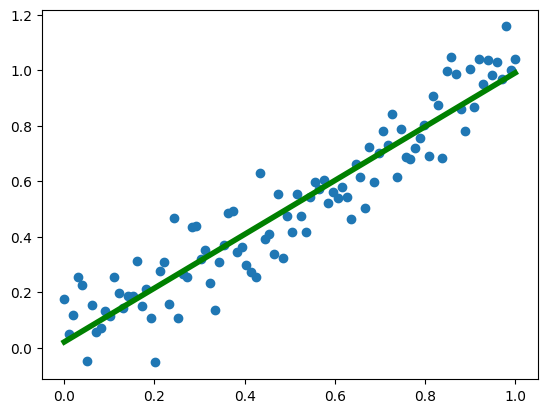

In [7]:
plt.scatter(x, y)
plt.plot(x, a * x + b, color="g", linewidth=4)

Udało ci się wytrenować swoją pierwszą sieć neuronową. Czemu? Otóż neuron to po prostu wektor parametrów, a zwykle robimy iloczyn skalarny tych parametrów z wejściem. Dodatkowo na wyjście nakłada się **funkcję aktywacji (activation function)**, która przekształca wyjście. Tutaj takiej nie było, a właściwie była to po prostu funkcja identyczności.

Oczywiście w praktyce korzystamy z odpowiedniego frameworka, który w szczególności:
- ułatwia budowanie sieci, np. ma gotowe klasy dla warstw neuronów
- ma zaimplementowane funkcje kosztu oraz ich pochodne
- sam różniczkuje ze względu na odpowiednie parametry i aktualizuje je odpowiednio podczas treningu


## Wprowadzenie do PyTorcha

PyTorch to w gruncie rzeczy narzędzie do algebry liniowej z [automatycznym rożniczkowaniem](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html), z możliwością przyspieszenia obliczeń z pomocą GPU. Na tych fundamentach zbudowany jest pełny framework do uczenia głębokiego. Można spotkać się ze stwierdzenie, że PyTorch to NumPy + GPU + opcjonalne różniczkowanie, co jest całkiem celne. Plus można łatwo debugować printem :)

PyTorch używa dynamicznego grafu obliczeń, który sami definiujemy w kodzie. Takie podejście jest bardzo wygodne, elastyczne i pozwala na łatwe eksperymentowanie. Odbywa się to potencjalnie kosztem wydajności, ponieważ pozostawia kwestię optymalizacji programiście. Więcej na ten temat dla zainteresowanych na końcu laboratorium.

Samo API PyTorcha bardzo przypomina Numpy'a, a podstawowym obiektem jest `Tensor`, klasa reprezentująca tensory dowolnego wymiaru. Dodatkowo niektóre tensory będą miały automatycznie obliczony gradient. Co ważne, tensor jest na pewnym urządzeniu, CPU lub GPU, a przenosić między nimi trzeba explicite.

Najważniejsze moduły:
- `torch` - podstawowe klasy oraz funkcje, np. `Tensor`, `from_numpy()`
- `torch.nn` - klasy związane z sieciami neuronowymi, np. `Linear`, `Sigmoid`
- `torch.optim` - wszystko związane z optymalizacją, głównie spadkiem wzdłuż gradientu

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

In [9]:
ones = torch.ones(10)
noise = torch.ones(10) * torch.rand(10)

# elementwise sum
print(ones + noise)

# elementwise multiplication
print(ones * noise)

# dot product
print(ones @ noise)

tensor([1.8110, 1.5298, 1.2533, 1.1548, 1.7362, 1.7558, 1.3641, 1.2627, 1.8257,
        1.9822])
tensor([0.8110, 0.5298, 0.2533, 0.1548, 0.7362, 0.7558, 0.3641, 0.2627, 0.8257,
        0.9822])
tensor(5.6758)


In [10]:
# beware - shares memory with original Numpy array!
# very fast, but modifications are visible to original variable
x = torch.from_numpy(x)
y = torch.from_numpy(y)

Jeżeli dla stworzonych przez nas tensorów chcemy śledzić operacje i obliczać gradient, to musimy oznaczyć `requires_grad=True`.

In [11]:
a = torch.rand(1, requires_grad=True)
b = torch.rand(1, requires_grad=True)
a, b

(tensor([0.5939], requires_grad=True), tensor([0.3928], requires_grad=True))

PyTorch zawiera większość powszechnie używanych funkcji kosztu, np. MSE. Mogą być one używane na 2 sposoby, z czego pierwszy jest popularniejszy:
- jako klasy wywoływalne z modułu `torch.nn`
- jako funkcje z modułu `torch.nn.functional`

Po wykonaniu poniższego kodu widzimy, że zwraca on nam tensor z dodatkowymi atrybutami. Co ważne, jest to skalar (0-wymiarowy tensor), bo potrzebujemy zwyczajnej liczby do obliczania propagacji wstecznych (pochodnych czątkowych).

In [12]:
mse = nn.MSELoss()
mse(y, a * x + b)

tensor(0.0559, dtype=torch.float64, grad_fn=<MseLossBackward0>)

Atrybutu `grad_fn` nie używamy wprost, bo korzysta z niego w środku PyTorch, ale widać, że tensor jest "świadomy", że liczy się na nim pochodną. Możemy natomiast skorzystać z atrybutu `grad`, który zawiera faktyczny gradient. Zanim go jednak dostaniemy, to trzeba powiedzieć PyTorchowi, żeby policzył gradient. Służy do tego metoda `.backward()`, wywoływana na obiekcie zwracanym przez funkcję kosztu.

In [13]:
loss = mse(y, a * x + b)
loss.backward()

In [14]:
print(a.grad)

tensor([0.1197])


Ważne jest, że PyTorch nie liczy za każdym razem nowego gradientu, tylko dodaje go do istniejącego, czyli go akumuluje. Jest to przydatne w niektórych sieciach neuronowych, ale zazwyczaj trzeba go zerować. Jeżeli tego nie zrobimy, to dostaniemy coraz większe gradienty.

Do zerowania służy metoda `.zero_()`. W PyTorchu wszystkie metody modyfikujące tensor w miejscu mają `_` na końcu nazwy. Jest to dość niskopoziomowa operacja dla pojedynczych tensorów - zobaczymy za chwilę, jak to robić łatwiej dla całej sieci.

In [15]:
loss = mse(y, a * x + b)
loss.backward()
a.grad

tensor([0.2394])

Zobaczmy, jak wyglądałaby regresja liniowa, ale napisana w PyTorchu. Jest to oczywiście bardzo niskopoziomowa implementacja - za chwilę zobaczymy, jak to wygląda w praktyce.

In [16]:
learning_rate = 0.1
for i in range(1000):
    loss = mse(y, a * x + b)

    # compute gradients
    loss.backward()

    # update parameters
    a.data -= learning_rate * a.grad
    b.data -= learning_rate * b.grad

    # zero gradients
    a.grad.data.zero_()
    b.grad.data.zero_()

    if i % 100 == 0:
        print(f"step {i} loss: ", loss)

print("final loss:", loss)

step 0 loss:  tensor(0.0559, dtype=torch.float64, grad_fn=<MseLossBackward0>)
step 100 loss:  tensor(0.0112, dtype=torch.float64, grad_fn=<MseLossBackward0>)
step 200 loss:  tensor(0.0102, dtype=torch.float64, grad_fn=<MseLossBackward0>)
step 300 loss:  tensor(0.0101, dtype=torch.float64, grad_fn=<MseLossBackward0>)
step 400 loss:  tensor(0.0101, dtype=torch.float64, grad_fn=<MseLossBackward0>)
step 500 loss:  tensor(0.0101, dtype=torch.float64, grad_fn=<MseLossBackward0>)
step 600 loss:  tensor(0.0101, dtype=torch.float64, grad_fn=<MseLossBackward0>)
step 700 loss:  tensor(0.0101, dtype=torch.float64, grad_fn=<MseLossBackward0>)
step 800 loss:  tensor(0.0101, dtype=torch.float64, grad_fn=<MseLossBackward0>)
step 900 loss:  tensor(0.0101, dtype=torch.float64, grad_fn=<MseLossBackward0>)
final loss: tensor(0.0101, dtype=torch.float64, grad_fn=<MseLossBackward0>)


Trening modeli w PyTorchu jest dosyć schematyczny i najczęściej rozdziela się go na kilka bloków, dających razem **pętlę uczącą (training loop)**, powtarzaną w każdej epoce:
1. Forward pass - obliczenie predykcji sieci
2. Loss calculation
3. Backpropagation - obliczenie pochodnych oraz zerowanie gradientów
4. Optimalization - aktualizacja wag
5. Other - ewaluacja na zbiorze walidacyjnym, logging etc.

In [17]:
# initialization
learning_rate = 0.1
a = torch.rand(1, requires_grad=True)
b = torch.rand(1, requires_grad=True)
optimizer = torch.optim.SGD([a, b], lr=learning_rate)
best_loss = float("inf")

# training loop in each epoch
for i in range(1000):
    # forward pass
    y_hat = a * x + b

    # loss calculation
    loss = mse(y, y_hat)

    # backpropagation
    loss.backward()

    # optimization
    optimizer.step()
    optimizer.zero_grad()  # zeroes all gradients - very convenient!

    if i % 100 == 0:
        if loss < best_loss:
            best_model = (a.clone(), b.clone())
            best_loss = loss
        print(f"step {i} loss: {loss.item():.4f}")

print("final loss:", loss)

step 0 loss: 0.0974
step 100 loss: 0.0131
step 200 loss: 0.0103
step 300 loss: 0.0101
step 400 loss: 0.0101
step 500 loss: 0.0101
step 600 loss: 0.0101
step 700 loss: 0.0101
step 800 loss: 0.0101
step 900 loss: 0.0101
final loss: tensor(0.0101, dtype=torch.float64, grad_fn=<MseLossBackward0>)


Przejdziemy teraz do budowy sieci neuronowej do klasyfikacji. Typowo implementuje się ją po prostu jako sieć dla regresji, ale zwracającą tyle wyników, ile mamy klas, a potem aplikuje się na tym funkcję sigmoidalną (2 klasy) lub softmax (>2 klasy). W przypadku klasyfikacji binarnej zwraca się czasem tylko 1 wartość, przepuszczaną przez sigmoidę - wtedy wyjście z sieci to prawdopodobieństwo klasy pozytywnej.

Funkcją kosztu zwykle jest **entropia krzyżowa (cross-entropy)**, stosowana też w klasycznej regresji logistycznej. Co ważne, sieci neuronowe, nawet tak proste, uczą się szybciej i stabilniej, gdy dane na wejściu (a przynajmniej zmienne numeryczne) są **ustandaryzowane (standardized)**. Operacja ta polega na odjęciu średniej i podzieleniu przez odchylenie standardowe (tzw. *Z-score transformation*).

**Uwaga - PyTorch wymaga tensora klas będącego liczbami zmiennoprzecinkowymi!**

## Zbiór danych

Na tym laboratorium wykorzystamy zbiór [Adult Census](https://archive.ics.uci.edu/ml/datasets/adult). Dotyczy on przewidywania na podstawie danych demograficznych, czy dany człowiek zarabia powyżej 50 tysięcy dolarów rocznie, czy też mniej. Jest to cenna informacja np. przy planowaniu kampanii marketingowych. Jak możesz się domyślić, zbiór pochodzi z czasów, kiedy inflacja była dużo niższa :)

Poniżej znajduje się kod do ściągnięcia i preprocessingu zbioru. Nie musisz go dokładnie analizować.

In [18]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2023-11-23 21:49:20--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘adult.data’

adult.data              [   <=>              ]   3.79M  6.75MB/s    in 0.6s    

2023-11-23 21:49:21 (6.75 MB/s) - ‘adult.data’ saved [3974305]



In [19]:
import pandas as pd


columns = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education-num",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    "native-country",
    "wage"
]

"""
age: continuous.
workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
fnlwgt: continuous.
education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
education-num: continuous.
marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
sex: Female, Male.
capital-gain: continuous.
capital-loss: continuous.
hours-per-week: continuous.
native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.
"""

df = pd.read_csv("adult.data", header=None, names=columns)
df.wage.unique()

array([' <=50K', ' >50K'], dtype=object)

In [20]:
# attribution: https://www.kaggle.com/code/royshih23/topic7-classification-in-python
df['education'].replace('Preschool', 'dropout',inplace=True)
df['education'].replace('10th', 'dropout',inplace=True)
df['education'].replace('11th', 'dropout',inplace=True)
df['education'].replace('12th', 'dropout',inplace=True)
df['education'].replace('1st-4th', 'dropout',inplace=True)
df['education'].replace('5th-6th', 'dropout',inplace=True)
df['education'].replace('7th-8th', 'dropout',inplace=True)
df['education'].replace('9th', 'dropout',inplace=True)
df['education'].replace('HS-Grad', 'HighGrad',inplace=True)
df['education'].replace('HS-grad', 'HighGrad',inplace=True)
df['education'].replace('Some-college', 'CommunityCollege',inplace=True)
df['education'].replace('Assoc-acdm', 'CommunityCollege',inplace=True)
df['education'].replace('Assoc-voc', 'CommunityCollege',inplace=True)
df['education'].replace('Bachelors', 'Bachelors',inplace=True)
df['education'].replace('Masters', 'Masters',inplace=True)
df['education'].replace('Prof-school', 'Masters',inplace=True)
df['education'].replace('Doctorate', 'Doctorate',inplace=True)

df['marital-status'].replace('Never-married', 'NotMarried',inplace=True)
df['marital-status'].replace(['Married-AF-spouse'], 'Married',inplace=True)
df['marital-status'].replace(['Married-civ-spouse'], 'Married',inplace=True)
df['marital-status'].replace(['Married-spouse-absent'], 'NotMarried',inplace=True)
df['marital-status'].replace(['Separated'], 'Separated',inplace=True)
df['marital-status'].replace(['Divorced'], 'Separated',inplace=True)
df['marital-status'].replace(['Widowed'], 'Widowed',inplace=True)

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler


X = df.copy()
y = (X.pop("wage") == ' >50K').astype(int).values

train_valid_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=train_valid_size,
    random_state=0,
    shuffle=True,
    stratify=y
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train,
    test_size=train_valid_size,
    random_state=0,
    shuffle=True,
    stratify=y_train
)

continuous_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
continuous_X_train = X_train[continuous_cols]
categorical_X_train = X_train.loc[:, ~X_train.columns.isin(continuous_cols)]

continuous_X_valid = X_valid[continuous_cols]
categorical_X_valid = X_valid.loc[:, ~X_valid.columns.isin(continuous_cols)]

continuous_X_test = X_test[continuous_cols]
categorical_X_test = X_test.loc[:, ~X_test.columns.isin(continuous_cols)]

categorical_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
continuous_scaler = StandardScaler() #MinMaxScaler(feature_range=(-1, 1))

categorical_encoder.fit(categorical_X_train)
continuous_scaler.fit(continuous_X_train)

continuous_X_train = continuous_scaler.transform(continuous_X_train)
continuous_X_valid = continuous_scaler.transform(continuous_X_valid)
continuous_X_test = continuous_scaler.transform(continuous_X_test)

categorical_X_train = categorical_encoder.transform(categorical_X_train)
categorical_X_valid = categorical_encoder.transform(categorical_X_valid)
categorical_X_test = categorical_encoder.transform(categorical_X_test)

X_train = np.concatenate([continuous_X_train, categorical_X_train], axis=1)
X_valid = np.concatenate([continuous_X_valid, categorical_X_valid], axis=1)
X_test = np.concatenate([continuous_X_test, categorical_X_test], axis=1)

X_train.shape, y_train.shape

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


((20838, 108), (20838,))

Uwaga co do typów - PyTorchu wszystko w sieci neuronowej musi być typu `float32`. W szczególności trzeba uważać na konwersje z Numpy'a, który używa domyślnie typu `float64`. Może ci się przydać metoda `.float()`.

Uwaga co do kształtów wyjścia - wejścia do `nn.BCELoss` muszą być tego samego kształtu. Może ci się przydać metoda `.squeeze()` lub `.unsqueeze()`.

In [22]:
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float().unsqueeze(-1)

X_valid = torch.from_numpy(X_valid).float()
y_valid = torch.from_numpy(y_valid).float().unsqueeze(-1)

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float().unsqueeze(-1)

Podobnie jak w laboratorium 2, mamy tu do czynienia z klasyfikacją niezbalansowaną:

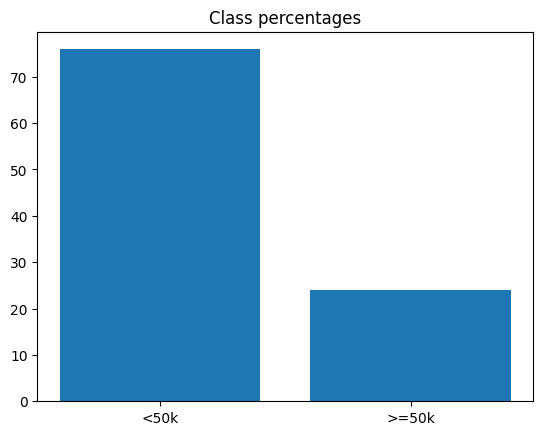

In [23]:
import matplotlib.pyplot as plt

y_pos_perc = 100 * y_train.sum().item() / len(y_train)
y_neg_perc = 100 - y_pos_perc

plt.title("Class percentages")
plt.bar(["<50k", ">=50k"], [y_neg_perc, y_pos_perc])
plt.show()

W związku z powyższym będziemy używać odpowiednich metryk, czyli AUROC, precyzji i czułości.

#### Zadanie 3 (1.0 punkt)

Zaimplementuj regresję logistyczną dla tego zbioru danych, używając PyTorcha. Dane wejściowe zostały dla ciebie przygotowane w komórkach poniżej.

Sama sieć składa się z 2 elementów:
- warstwa liniowa `nn.Linear`, przekształcająca wektor wejściowy na 1 wyjście - logit
- aktywacja sigmoidalna `nn.Sigmoid`, przekształcająca logit na prawdopodobieństwo klasy pozytywnej

Użyj binarnej entropii krzyżowej `nn.BCELoss` jako funkcji kosztu. Użyj optymalizatora SGD ze stałą uczącą `1e-3`. Trenuj przez 3000 epok. Pamiętaj, aby przekazać do optymalizatora `torch.optim.SGD` parametry sieci (metoda `.parameters()`). Dopisz logowanie kosztu raz na 100 epok.

In [24]:
learning_rate = 1e-3

model = ...
activation = ...
optimizer = ...
loss_fn = ...

# implement me!
# your_code

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

input_size = X_train.shape[1]
model = LogisticRegressionModel(input_size)
activation = nn.Sigmoid()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.BCELoss()

num_epochs = 3000

for epoch in range(num_epochs):

    y_pred = model(X_train)

    loss = loss_fn(y_pred, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')



Epoch [100/3000], Loss: 0.6336
Epoch [200/3000], Loss: 0.6128
Epoch [300/3000], Loss: 0.5948
Epoch [400/3000], Loss: 0.5793
Epoch [500/3000], Loss: 0.5656
Epoch [600/3000], Loss: 0.5536
Epoch [700/3000], Loss: 0.5429
Epoch [800/3000], Loss: 0.5334
Epoch [900/3000], Loss: 0.5247
Epoch [1000/3000], Loss: 0.5169
Epoch [1100/3000], Loss: 0.5097
Epoch [1200/3000], Loss: 0.5032
Epoch [1300/3000], Loss: 0.4971
Epoch [1400/3000], Loss: 0.4915
Epoch [1500/3000], Loss: 0.4863
Epoch [1600/3000], Loss: 0.4814
Epoch [1700/3000], Loss: 0.4769
Epoch [1800/3000], Loss: 0.4726
Epoch [1900/3000], Loss: 0.4686
Epoch [2000/3000], Loss: 0.4648
Epoch [2100/3000], Loss: 0.4612
Epoch [2200/3000], Loss: 0.4578
Epoch [2300/3000], Loss: 0.4546
Epoch [2400/3000], Loss: 0.4515
Epoch [2500/3000], Loss: 0.4486
Epoch [2600/3000], Loss: 0.4458
Epoch [2700/3000], Loss: 0.4431
Epoch [2800/3000], Loss: 0.4406
Epoch [2900/3000], Loss: 0.4382
Epoch [3000/3000], Loss: 0.4359


Teraz trzeba sprawdzić, jak poszło naszej sieci. W PyTorchu sieć pracuje zawsze w jednym z dwóch trybów: treningowym lub ewaluacyjnym (predykcyjnym). Ten drugi wyłącza niektóre mechanizmy, które są używane tylko podczas treningu, w szczególności regularyzację dropout. Do przełączania służą metody modelu `.train()` i `.eval()`.

Dodatkowo podczas liczenia predykcji dobrze jest wyłączyć liczenie gradientów, bo nie będą potrzebne, a oszczędza to czas i pamięć. Używa się do tego menadżera kontekstu `with torch.no_grad():`.

In [25]:
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support, roc_auc_score


model.eval()
with torch.no_grad():
    y_score = activation(model(X_test))

auroc = roc_auc_score(y_test, y_score)
print(f"AUROC: {100 * auroc:.2f}%")

AUROC: 85.70%


Jest to całkiem dobry wynik, a może być jeszcze lepszy. Sprawdźmy dla pewności jeszcze inne metryki: precyzję, recall oraz F1-score. Dodatkowo narysujemy krzywą precision-recall, czyli jak zmieniają się te metryki w zależności od przyjętego progu (threshold) prawdopodobieństwa, powyżej którego przyjmujemy klasę pozytywną. Taką krzywą należy rysować na zbiorze walidacyjnym, bo później chcemy wykorzystać tę informację do doboru progu, a nie chcemy mieć wycieku danych testowych (data leakage).

Poniżej zaimplementowano także funkcję `get_optimal_threshold()`, która sprawdza, dla którego progu uzyskujemy maksymalny F1-score, i zwraca indeks oraz wartość optymalnego progu. Przyda ci się ona w dalszej części laboratorium.

In [26]:
from sklearn.metrics import PrecisionRecallDisplay


def get_optimal_threshold(
    precisions: np.array,
    recalls: np.array,
    thresholds: np.array
) -> Tuple[int, float]:

    numerator = 2 * precisions * recalls
    denominator = precisions + recalls
    f1_scores = np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator != 0)

    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]

    return optimal_idx, optimal_threshold


def plot_precision_recall_curve(y_true, y_pred_score) -> None:
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred_score)
    optimal_idx, optimal_threshold = get_optimal_threshold(precisions, recalls, thresholds)

    disp = PrecisionRecallDisplay(precisions, recalls)
    disp.plot()
    plt.title(f"Precision-recall curve (opt. thresh.: {optimal_threshold:.4f})")
    plt.axvline(recalls[optimal_idx], color="green", linestyle="-.")
    plt.axhline(precisions[optimal_idx], color="green", linestyle="-.")
    plt.show()


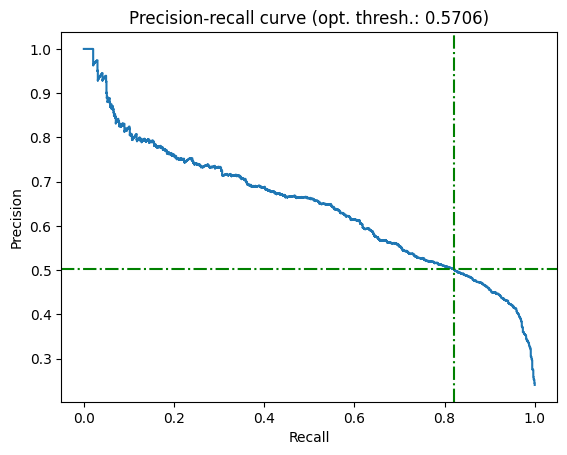

In [27]:
model.eval()
with torch.no_grad():
    y_pred_valid_score = activation(model(X_valid))

plot_precision_recall_curve(y_valid, y_pred_valid_score)

Jak widać, chociaż AUROC jest wysokie, to dla optymalnego F1-score recall nie jest zbyt wysoki, a precyzja jest już dość niska. Być może wynik uda się poprawić, używając modelu o większej pojemności - pełnej, głębokiej sieci neuronowej.

## Sieci neuronowe

Wszystko zaczęło się od inspirowanych biologią [sztucznych neuronów](https://en.wikipedia.org/wiki/Artificial_neuron), których próbowano użyć do symulacji mózgu. Naukowcy szybko odeszli od tego podejścia (sam problem modelowania okazał się też znacznie trudniejszy, niż sądzono), zamiast tego używając neuronów jako jednostek reprezentującą dowolną funkcję parametryczną $f(x, \Theta)$. Każdy neuron jest zatem bardzo elastyczny, bo jedyne wymagania to funkcja różniczkowalna, a mamy do tego wektor parametrów $\Theta$.

W praktyce najczęściej można spotkać się z kilkoma rodzinami sieci neuronowych:
1. Perceptrony wielowarstwowe (*MultiLayer Perceptron*, MLP) - najbardziej podobne do powyższego opisu, niezbędne do klasyfikacji i regresji
2. Konwolucyjne (*Convolutional Neural Networks*, CNNs) - do przetwarzania danych z zależnościami przestrzennymi, np. obrazów czy dźwięku
3. Rekurencyjne (*Recurrent Neural Networks*, RNNs) - do przetwarzania danych z zależnościami sekwencyjnymi, np. szeregi czasowe, oraz kiedyś do języka naturalnego
4. Transformacyjne (*Transformers*), oparte o mechanizm atencji (*attention*) - do przetwarzania języka naturalnego (NLP), z którego wyparły RNNs, a coraz częściej także do wszelkich innych danych, np. obrazów, dźwięku
5. Grafowe (*Graph Neural Networks*, GNNS) - do przetwarzania grafów

Na tym laboratorium skupimy się na najprostszej architekturze, czyli MLP. Jest ona powszechnie łączona z wszelkimi innymi architekturami, bo pozwala dokonywać klasyfikacji i regresji. Przykładowo, klasyfikacja obrazów to zwykle CNN + MLP, klasyfikacja tekstów to transformer + MLP, a regresja na grafach to GNN + MLP.

Dodatkowo, pomimo prostoty MLP są bardzo potężne - udowodniono, że perceptrony (ich powszechna nazwa) są [uniwersalnym aproksymatorem](https://www.sciencedirect.com/science/article/abs/pii/0893608089900208), będącym w stanie przybliżyć dowolną funkcję z odpowiednio małym błędem, zakładając wystarczającą wielkość warstw sieci. Szczególne ich wersje potrafią nawet [reprezentować drzewa decyzyjne](https://www.youtube.com/watch?v=_okxGdHM5b8).

Dla zainteresowanych polecamy [doskonałą książkę "Dive into Deep Learning", z implementacjami w PyTorchu](https://d2l.ai/chapter_multilayer-perceptrons/index.html), [klasyczną książkę "Deep Learning Book"](https://www.deeplearningbook.org/contents/mlp.html), oraz [ten filmik](https://www.youtube.com/watch?v=BFHrIxKcLjA), jeśli zastanawiałeś/-aś się, czemu używamy deep learning, a nie naprzykład (wide?) learning. (aka. czemu staramy się budować głębokie sieci, a nie płytkie za to szerokie)

### Sieci MLP

Dla przypomnienia, na wejściu mamy punkty ze zbioru treningowego, czyli $d$-wymiarowe wektory. W klasyfikacji chcemy znaleźć granicę decyzyjną, czyli krzywą, która oddzieli od siebie klasy. W wejściowej przestrzeni może być to trudne, bo chmury punktów z poszczególnych klas mogą być ze sobą dość pomieszane. Pamiętajmy też, że regresja logistyczna jest klasyfikatorem liniowym, czyli w danej przestrzeni potrafi oddzielić punkty tylko linią prostą.

Sieć MLP składa się z warstw. Każda z nich dokonuje nieliniowego przekształcenia przestrzeni (można o tym myśleć jak o składaniu przestrzeni jakąś prostą/łamaną), tak, aby w finalnej przestrzeni nasze punkty były możliwie liniowo separowalne. Wtedy ostatnia warstwa z sigmoidą będzie potrafiła je rozdzielić od siebie.

![1_x-3NGQv0pRIab8xDT-f_Hg.png](attachment:1_x-3NGQv0pRIab8xDT-f_Hg.png)

Poszczególne neurony składają się z iloczynu skalarnego wejść z wagami neuronu, oraz nieliniowej funkcji aktywacji. W PyTorchu są to osobne obiekty - `nn.Linear` oraz np. `nn.Sigmoid`. Funkcja aktywacji przyjmuje wynik iloczynu skalarnego i przekształca go, aby sprawdzić, jak mocno reaguje neuron na dane wejście. Musi być nieliniowa z dwóch powodów. Po pierwsze, tylko nieliniowe przekształcenia są na tyle potężne, żeby umożliwić liniową separację danych w ostatniej warstwie. Po drugie, liniowe przekształcenia zwyczajnie nie działają. Aby zrozumieć czemu, trzeba zobaczyć, co matematycznie oznacza sieć MLP.

![perceptron](https://www.saedsayad.com/images/Perceptron_bkp_1.png)

Zapisane matematycznie MLP to:

$\large
h_1 = f_1(x) \\
h_2 = f_2(h_1) \\
h_3 = f_3(h_2) \\
... \\
h_n = f_n(h_{n-1})
$

gdzie $x$ to wejście $f_i$ to funkcja aktywacji $i$-tej warstwy, a $h_i$ to wyjście $i$-tej warstwy, nazywane **ukrytą reprezentacją (hidden representation)**, lub *latent representation*. Nazwa bierze się z tego, że w środku sieci wyciągamy cechy i wzorce w danych, które nie są widoczne na pierwszy rzut oka na wejściu.

Załóżmy, że uczymy się na danych $x$ o jednym wymiarze (dla uproszczenia wzorów) oraz nie mamy funkcji aktywacji, czyli wykorzystujemy tak naprawdę aktywację liniową $f(x) = x$. Zobaczmy jak będą wyglądać dane przechodząc przez kolejne warstwy:

$\large
h_1 = f_1(xw_1) = xw_1 \\
h_2 = f_2(h_1w_2) = xw_1w_2 \\
... \\
h_n = f_n(h_{n-1}w_n) = xw_1w_2...w_n
$

gdzie $w_i$ to jest parametr $i$-tej warstwy sieci, $x$ to są dane (w naszym przypadku jedna liczba) wejściowa, a $h_i$ to wyjście $i$-tej warstwy.

Jak widać, taka sieć o $n$ warstwach jest równoważna sieci o jednej warstwie z parametrem $w = w_1w_2...w_n$. Wynika to z tego, że złożenie funkcji liniowych jest także funkcją liniową - patrz notatki z algebry :)

Jeżeli natomiast użyjemy nieliniowej funkcji aktywacji, często oznaczanej jako $\sigma$, to wszystko będzie działać. Co ważne, ostatnia warstwa, dająca wyjście sieci, ma zwykle inną aktywację od warstw wewnątrz sieci, bo też ma inne zadanie - zwrócić wartość dla klasyfikacji lub regresji. Na wyjściu korzysta się z funkcji liniowej (regresja), sigmoidalnej (klasyfikacja binarna) lub softmax (klasyfikacja wieloklasowa).

Wewnątrz sieci używano kiedyś sigmoidy oraz tangensa hiperbolicznego `tanh`, ale okazało się to nieefektywne przy uczeniu głębokich sieci o wielu warstwach. Nowoczesne sieci korzystają zwykle z funkcji ReLU (*rectified linear unit*), która jest zaskakująco prosta: $ReLU(x) = \max(0, x)$. Okazało się, że bardzo dobrze nadaje się do treningu nawet bardzo głębokich sieci neuronowych. Nowsze funkcje aktywacji są głównie modyfikacjami ReLU.

![relu](https://www.nomidl.com/wp-content/uploads/2022/04/image-10.png)

### MLP w PyTorchu

Warstwę neuronów w MLP nazywa się warstwą gęstą (*dense layer*) lub warstwą w pełni połączoną (*fully-connected layer*), i taki opis oznacza zwykle same neurony oraz funkcję aktywacji. PyTorch, jak już widzieliśmy, definiuje osobno transformację liniową oraz aktywację, a więc jedna warstwa składa się de facto z 2 obiektów, wywoływanych jeden po drugim. Inne frameworki, szczególnie wysokopoziomowe (np. Keras) łączą to często w jeden obiekt.

MLP składa się zatem z sekwencji obiektów, które potem wywołuje się jeden po drugim, gdzie wyjście poprzedniego to wejście kolejnego. Ale nie można tutaj używać Pythonowych list! Z perspektywy PyTorcha to wtedy niezależne obiekty i nie zostanie wtedy przekazany między nimi gradient. Trzeba tutaj skorzystać z `nn.Sequential`, aby tworzyć taki pipeline.

Rozmiary wejścia i wyjścia dla każdej warstwy trzeba w PyTorchu podawać explicite. Jest to po pierwsze edukacyjne, a po drugie często ułatwia wnioskowanie o działaniu sieci oraz jej debugowanie - mamy jasno podane, czego oczekujemy. Niektóre frameworki (np. Keras) obliczają to automatycznie.

Co ważne, ostatnia warstwa zwykle nie ma funkcji aktywacji. Wynika to z tego, że obliczanie wielu funkcji kosztu (np. entropii krzyżowej) na aktywacjach jest często niestabilne numerycznie. Z tego powodu PyTorch oferuje funkcje kosztu zawierające w środku aktywację dla ostatniej warstwy, a ich implementacje są stabilne numerycznie. Przykładowo, `nn.BCELoss` przyjmuje wejście z zaaplikowanymi już aktywacjami, ale może skutkować under/overflow, natomiast `nn.BCEWithLogitsLoss` przyjmuje wejście bez aktywacji, a w środku ma specjalną implementację łączącą binarną entropię krzyżową z aktywacją sigmoidalną. Oczywiście w związku z tym aby dokonać potem predykcji w praktyce, trzeba pamiętać o użyciu funkcji aktywacji. Często korzysta się przy tym z funkcji z modułu `torch.nn.functional`, które są w tym wypadku nieco wygodniejsze od klas wywoływalnych z `torch.nn`.

Całe sieci w PyTorchu tworzy się jako klasy dziedziczące po `nn.Module`. Co ważne, obiekty, z których tworzymy sieć, np. `nn.Linear`, także dziedziczą po tej klasie. Pozwala to na bardzo modułową budowę kodu, zgodną z zasadami OOP. W konstruktorze najpierw trzeba zawsze wywołać konstruktor rodzica - `super().__init__()`, a później tworzy się potrzebne obiekty i zapisuje jako atrybuty. Każdy atrybut dziedziczący po `nn.Module` lub `nn.Parameter` jest uważany za taki, który zawiera parametry sieci, a więc przy wywołaniu metody `parameters()` - parametry z tych atrybutów pojawią się w liście wszystkich parametrów. Musimy też zdefiniować metodę `forward()`, która przyjmuje tensor `x` i zwraca wynik. Typowo ta metoda po prostu używa obiektów zdefiniowanych w konstruktorze.


**UWAGA: nigdy w normalnych warunkach się nie woła metody `forward` ręcznie**

#### Zadanie 4 (0.5 punktu)

Uzupełnij implementację 3-warstwowej sieci MLP. Użyj rozmiarów:
* pierwsza warstwa: input_size x 256
* druga warstwa: 256 x 128
* trzecia warstwa: 128 x 1

Użyj funkcji aktywacji ReLU.

Przydatne klasy:
- `nn.Sequential`
- `nn.Linear`
- `nn.ReLU`

In [28]:
from torch import sigmoid


class MLP(nn.Module):
    def __init__(self, input_size: int):
        super(MLP, self).__init__()

        # implement me!
        # your_code
        self.layers = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        # implement me!
        # your_code
        return self.layers(x)

    def predict_proba(self, x):
        return sigmoid(self(x))

    def predict(self, x, threshold: float = 0.5):
        y_pred_score = self.predict_proba(x)
        return (y_pred_score > threshold).to(torch.int32)


In [29]:
learning_rate = 1e-3
model = MLP(input_size=X_train.shape[1])
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# note that we are using loss function with sigmoid built in
loss_fn = torch.nn.BCEWithLogitsLoss()
num_epochs = 2000
evaluation_steps = 200

for i in range(num_epochs):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

    if i % evaluation_steps == 0:
        print(f"Epoch {i} train loss: {loss.item():.4f}")

print(f"final loss: {loss.item():.4f}")

Epoch 0 train loss: 0.6803
Epoch 200 train loss: 0.6592
Epoch 400 train loss: 0.6413
Epoch 600 train loss: 0.6258
Epoch 800 train loss: 0.6122
Epoch 1000 train loss: 0.6003
Epoch 1200 train loss: 0.5897
Epoch 1400 train loss: 0.5803
Epoch 1600 train loss: 0.5719
Epoch 1800 train loss: 0.5644
final loss: 0.5576


AUROC: 81.89%


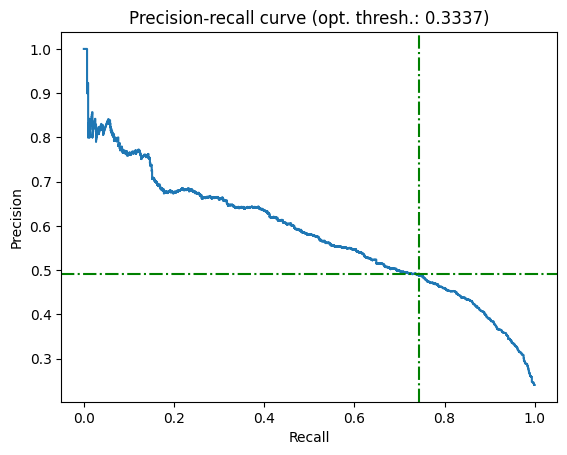

In [30]:
model.eval()
with torch.no_grad():
    # positive class probabilities
    y_pred_valid_score = model.predict_proba(X_valid)
    y_pred_test_score = model.predict_proba(X_test)

auroc = roc_auc_score(y_test, y_pred_test_score)
print(f"AUROC: {100 * auroc:.2f}%")

plot_precision_recall_curve(y_valid, y_pred_valid_score)

AUROC jest podobne, a precision i recall spadły - wypadamy wręcz gorzej od regresji liniowej! Skoro dodaliśmy więcej warstw, to może pojemność modelu jest teraz za duża i trzeba by go zregularyzować?

Sieci neuronowe bardzo łatwo przeuczają, bo są bardzo elastycznymi i pojemnymi modelami. Dlatego mają wiele różnych rodzajów regularyzacji, których używa się razem. Co ciekawe, udowodniono eksperymentalnie, że zbyt duże sieci z mocną regularyzacją działają lepiej niż mniejsze sieci, odpowiedniego rozmiaru, za to ze słabszą regularyzacją.

Pierwszy rodzaj regularyzacji to znana nam już **regularyzacja L2**, czyli penalizacja zbyt dużych wag. W kontekście sieci neuronowych nazywa się też ją czasem *weight decay*. W PyTorchu dodaje się ją jako argument do optymalizatora.

Regularyzacja specyficzna dla sieci neuronowych to **dropout**. Polega on na losowym wyłączaniu zadanego procenta neuronów podczas treningu. Pomimo prostoty okazała się niesamowicie skuteczna, szczególnie w treningu bardzo głębokich sieci. Co ważne, jest to mechanizm używany tylko podczas treningu - w trakcie predykcji za pomocą sieci wyłącza się ten mechanizm i dokonuje normalnie predykcji całą siecią. Podejście to można potraktować jak ensemble learning, podobny do lasów losowych - wyłączając losowe części sieci, w każdej iteracji trenujemy nieco inną sieć, co odpowiada uśrednianiu predykcji różnych algorytmów. Typowo stosuje się dość mocny dropout, rzędu 25-50%. W PyTorchu implementuje go warstwa `nn.Dropout`, aplikowana zazwyczaj po funkcji aktywacji.

Ostatni, a być może najważniejszy rodzaj regularyzacji to **wczesny stop (early stopping)**. W każdym kroku mocniej dostosowujemy terenową sieć do zbioru treningowego, a więc zbyt długi trening będzie skutkował przeuczeniem. W metodzie wczesnego stopu używamy wydzielonego zbioru walidacyjnego (pojedynczego, metoda holdout), sprawdzając co określoną liczbę epok wynik na tym zbiorze. Jeżeli nie uzyskamy wyniku lepszego od najlepszego dotychczas uzyskanego przez określoną liczbę epok, to przerywamy trening. Okres, przez który czekamy na uzyskanie lepszego wyniku, to cierpliwość (*patience*). Im mniejsze, tym mocniejszy jest ten rodzaj regularyzacji, ale trzeba z tym uważać, bo łatwo jest przesadzić i zbyt szybko przerywać trening. Niektóre implementacje uwzględniają tzw. *grace period*, czyli gwarantowaną minimalną liczbę epok, przez którą będziemy trenować sieć, niezależnie od wybranej cierpliwości.

Dodatkowo ryzyko przeuczenia można zmniejszyć, używając mniejszej stałej uczącej.

#### Zadanie 5 (1.5 punktu)

Zaimplementuj funkcję `evaluate_model()`, obliczającą metryki na zbiorze testowym:
- wartość funkcji kosztu (loss)
- AUROC
- optymalny próg
- F1-score przy optymalnym progu
- precyzję oraz recall dla optymalnego progu

Jeżeli podana jest wartość argumentu `threshold`, to użyj jej do zamiany prawdopodobieństw na twarde predykcje. W przeciwnym razie użyj funkcji `get_optimal_threshold` i oblicz optymalną wartość progu.

Pamiętaj o przełączeniu modelu w tryb ewaluacji oraz o wyłączeniu obliczania gradientów.

In [31]:
from typing import Optional

from sklearn.metrics import precision_score, recall_score, f1_score
from torch import sigmoid

def get_optimal_threshold(y_true: torch.Tensor, y_pred_score: torch.Tensor) -> float:
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_score)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    optimal_threshold = thresholds[np.argmax(f1_scores)]
    return optimal_threshold


def evaluate_model(
    model: nn.Module,
    X: torch.Tensor,
    y: torch.Tensor,
    loss_fn: nn.Module,
    threshold: Optional[float]= None
) -> Dict[str, float]:
    # implement me!
    # your_code
    model.eval()

    with torch.no_grad():
        y_pred_score = model.predict_proba(X)

        # Obliczanie wartości funkcji kosztu
        loss = loss_fn(model(X), y).item()

        # Ustawienie progu, jeśli nie podano
        if threshold is None:
            threshold = get_optimal_threshold(y, y_pred_score)

        # Konwersja prawdopodobieństw na twarde predykcje zgodnie z ustalonym progiem
        y_pred = (y_pred_score > threshold).to(torch.int32)

        # Obliczanie metryk
        auroc = roc_auc_score(y.numpy(), y_pred_score.numpy())
        precision = precision_score(y.numpy(), y_pred.numpy())
        recall = recall_score(y.numpy(), y_pred.numpy())
        f1 = f1_score(y.numpy(), y_pred.numpy())

        return {
            'loss': loss,
            'AUROC': auroc,
            'optimal_threshold': threshold,
            'precision': precision,
            'recall': recall,
            'F1-score': f1
        }


#### Zadanie 6 (0.5 punktu)

Zaimplementuj 3-warstwową sieć MLP z dropout (50%). Rozmiary warstw ukrytych mają wynosić 256 i 128.

In [32]:
class RegularizedMLP(nn.Module):
    def __init__(self, input_size: int, dropout_p: float = 0.5):
        super().__init__()

        # implement me!
        # your_code
        super(RegularizedMLP, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(128, 1)
            )

    def forward(self, x):
        # implement me!
        # your_code
        return self.layers(x)

    def predict_proba(self, x):
        return sigmoid(self(x))

    def predict(self, x, threshold: float = 0.5):
        y_pred_score = self.predict_proba(x)
        return (y_pred_score > threshold).to(torch.int32)


Opisaliśmy wcześniej podstawowy optymalizator w sieciach neuronowych - spadek wzdłuż gradientu. Jednak wymaga on użycia całego zbioru danych, aby obliczyć gradient, co jest często niewykonalne przez rozmiar zbioru. Dlatego wymyślono **stochastyczny spadek wzdłuż gradientu (stochastic gradient descent, SGD)**, w którym używamy 1 przykładu naraz, liczymy gradient tylko po nim i aktualizujemy parametry. Jest to oczywiście dość grube przybliżenie gradientu, ale pozwala robić szybko dużo małych kroków. Kompromisem, którego używa się w praktyce, jest **minibatch gradient descent**, czyli używanie batchy np. 32, 64 czy 128 przykładów.

Rzadko wspominanym, a ważnym faktem jest także to, że stochastyczność metody optymalizacji jest sama w sobie też [metodą regularyzacji](https://arxiv.org/abs/2101.12176), a więc `batch_size` to także hiperparametr.

Obecnie najpopularniejszą odmianą SGD jest [Adam](https://arxiv.org/abs/1412.6980), gdyż uczy on szybko sieć oraz daje bardzo dobre wyniki nawet przy niekoniecznie idealnie dobranych hiperparametrach. W PyTorchu najlepiej korzystać z jego implementacji `AdamW`, która jest nieco lepsza niż implementacja `Adam`. Jest to zasadniczo zawsze wybór domyślny przy treningu współczesnych sieci neuronowych.

Na razie użyjemy jednak minibatch SGD.

Poniżej znajduje się implementacja prostej klasy dziedziczącej po `Dataset` - tak w PyTorchu implementuje się własne zbiory danych. Użycie takich klas umożliwia użycie klas ładujących dane (`DataLoader`), które z kolei pozwalają łatwo ładować batche danych. Trzeba w takiej klasie zaimplementować metody:
- `__len__` - zwraca ilość punktów w zbiorze
- `__getitem__` - zwraca przykład ze zbioru pod danym indeksem oraz jego klasę


In [33]:
from torch.utils.data import Dataset


class MyDataset(Dataset):
    def __init__(self, data, y):
        super().__init__()

        self.data = data
        self.y = y

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx], self.y[idx]


#### Zadanie 7 (1.5 punktu)

Zaimplementuj pętlę treningowo-walidacyjną dla sieci neuronowej. Wykorzystaj podane wartości hiperparametrów do treningu (stała ucząca, prawdopodobieństwo dropoutu, regularyzacja L2, rozmiar batcha, maksymalna liczba epok). Użyj optymalizatora SGD.

Dodatkowo zaimplementuj regularyzację przez early stopping. Sprawdzaj co epokę wynik na zbiorze walidacyjnym. Użyj podanej wartości patience, a jako metryki po prostu wartości funkcji kosztu. Może się tutaj przydać zaimplementowana funkcja `evaluate_model()`.

Pamiętaj o tym, aby przechowywać najlepszy dotychczasowy wynik walidacyjny oraz najlepszy dotychczasowy model. Zapamiętaj też optymalny próg do klasyfikacji dla najlepszego modelu.

In [34]:
from copy import deepcopy

from torch.utils.data import DataLoader


learning_rate = 1e-3
dropout_p = 0.5
l2_reg = 1e-4
batch_size = 128
max_epochs = 300

early_stopping_patience = 4

In [35]:
model = RegularizedMLP(
    input_size=X_train.shape[1],
    dropout_p=dropout_p
)
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=learning_rate,
    weight_decay=l2_reg
)
loss_fn = torch.nn.BCEWithLogitsLoss()

train_dataset = MyDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

steps_without_improvement = 0

best_val_loss = np.inf
best_model = None
best_threshold = None

for epoch_num in range(max_epochs):
    model.train()

    # note that we are using DataLoader to get batches
    for X_batch, y_batch in train_dataloader:
        # model training
        # implement me!
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # model evaluation, early stopping
    # implement me!
    valid_metrics = evaluate_model(model, X_valid, y_valid, loss_fn)
    val_loss = valid_metrics['loss']

    print(f"Epoch {epoch_num} train loss: {loss.item():.4f}, eval loss {valid_metrics['loss']}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = deepcopy(model)
        best_threshold = valid_metrics['optimal_threshold']
        steps_without_improvement = 0
    else:
        steps_without_improvement += 1

    if steps_without_improvement >= early_stopping_patience:
        print(f"Early stopping after {epoch_num} epochs.")
        break


Epoch 0 train loss: 0.6727, eval loss 0.6693463325500488
Epoch 1 train loss: 0.6538, eval loss 0.6537984013557434
Epoch 2 train loss: 0.6391, eval loss 0.6400370597839355
Epoch 3 train loss: 0.6229, eval loss 0.6277278661727905
Epoch 4 train loss: 0.6190, eval loss 0.6166834831237793
Epoch 5 train loss: 0.5951, eval loss 0.6067484021186829
Epoch 6 train loss: 0.5824, eval loss 0.5977854132652283
Epoch 7 train loss: 0.5898, eval loss 0.5896422863006592
Epoch 8 train loss: 0.5783, eval loss 0.582292377948761
Epoch 9 train loss: 0.5726, eval loss 0.575628936290741
Epoch 10 train loss: 0.5679, eval loss 0.5695186257362366
Epoch 11 train loss: 0.5647, eval loss 0.5638837814331055
Epoch 12 train loss: 0.5554, eval loss 0.5587821006774902
Epoch 13 train loss: 0.5446, eval loss 0.554095983505249
Epoch 14 train loss: 0.5268, eval loss 0.5497388243675232
Epoch 15 train loss: 0.5388, eval loss 0.5456777811050415
Epoch 16 train loss: 0.5451, eval loss 0.541844367980957
Epoch 17 train loss: 0.5284,

In [36]:
test_metrics = evaluate_model(best_model, X_test, y_test, loss_fn, best_threshold)

print(f"AUROC: {100 * test_metrics['AUROC']:.2f}%")
print(f"F1: {100 * test_metrics['F1-score']:.2f}%")
print(f"Precision: {100 * test_metrics['precision']:.2f}%")
print(f"Recall: {100 * test_metrics['recall']:.2f}%")

AUROC: 90.21%
F1: 68.82%
Precision: 62.78%
Recall: 76.15%


Wyniki wyglądają już dużo lepiej.

Na koniec laboratorium dołożymy do naszego modelu jeszcze 3 powrzechnie używane techniki, które są bardzo proste, a pozwalają często ulepszyć wynik modelu.

Pierwszą z nich są **warstwy normalizacji (normalization layers)**. Powstały one początkowo z założeniem, że przez przekształcenia przestrzeni dokonywane przez sieć zmienia się rozkład prawdopodobieństw pomiędzy warstwami, czyli tzw. *internal covariate shift*. Później okazało się, że zastosowanie takiej normalizacji wygładza powierzchnię funkcji kosztu, co ułatwia i przyspiesza optymalizację. Najpowszechniej używaną normalizacją jest **batch normalization (batch norm)**.

Drugim ulepszeniem jest dodanie **wag klas (class weights)**. Mamy do czynienia z problemem klasyfikacji niezbalansowanej, więc klasa mniejszościowa, ważniejsza dla nas, powinna dostać większą wagę. Implementuje się to trywialnie prosto - po prostu mnożymy wartość funkcji kosztu dla danego przykładu przez wagę dla prawdziwej klasy tego przykładu. Praktycznie każdy klasyfikator operujący na jakiejś ważonej funkcji może działać w ten sposób, nie tylko sieci neuronowe.

Ostatnim ulepszeniem jest zamiana SGD na optymalizator Adam, a konkretnie na optymalizator `AdamW`. Jest to przykład **optymalizatora adaptacyjnego (adaptive optimizer)**, który potrafi zaadaptować stałą uczącą dla każdego parametru z osobna w trakcie treningu. Wykorzystuje do tego gradienty - w uproszczeniu, im większa wariancja gradientu, tym mniejsze kroki w tym kierunku robimy.

#### Zadanie 8 (0.5 punktu)

Zaimplementuj model `NormalizingMLP`, o takiej samej strukturze jak `RegularizedMLP`, ale dodatkowo z warstwami `BatchNorm1d` pomiędzy warstwami `Linear` oraz `ReLU`.

Za pomocą funkcji `compute_class_weight()` oblicz wagi dla poszczególnych klas. Użyj opcji `"balanced"`. Przekaż do funkcji kosztu wagę klasy pozytywnej (pamiętaj, aby zamienić ją na tensor).

Zamień używany optymalizator na `AdamW`.

Na koniec skopiuj resztę kodu do treningu z poprzedniego zadania, wytrenuj sieć i oblicz wyniki na zbiorze testowym.

In [37]:
from sklearn.utils.class_weight import compute_class_weight

class NormalizingMLP(nn.Module):
    def __init__(self, input_size: int, dropout_p: float = 0.5):
        super(NormalizingMLP, self).__init__()

        # implement me!
        # your_code

        self.mlp = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.mlp(x)

    def predict_proba(self, x):
        return sigmoid(self(x))

    def predict(self, x, threshold: float = 0.5):
        y_pred_score = self.predict_proba(x)
        return (y_pred_score > threshold).to(torch.int32)


In [38]:
# define all the hyperparameters
# your_code

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=np.ravel(y_train))
class_weights_tensor = torch.tensor(class_weights[1], dtype=torch.float32)

model = NormalizingMLP(input_size=X_train.shape[1], dropout_p=dropout_p)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=l2_reg)
loss_fn = nn.BCEWithLogitsLoss(weight=class_weights_tensor)

In [39]:
# training loop
# your_code

train_dataset = MyDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

steps_without_improvement = 0

best_val_loss = np.inf
best_model = None
best_threshold = None

for epoch_num in range(max_epochs):
    model.train()

    # note that we are using DataLoader to get batches
    for X_batch, y_batch in train_dataloader:
        # model training
        # implement me!
        y_pred = model(X_batch)

        loss = loss_fn(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # model evaluation, early stopping
    # implement me!
    valid_metrics = evaluate_model(model, X_valid, y_valid, loss_fn)
    val_loss = valid_metrics['loss']

    print(f"Epoch {epoch_num} train loss: {loss.item():.4f}, eval loss {valid_metrics['loss']}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = deepcopy(model)
        best_threshold = valid_metrics['optimal_threshold']
        steps_without_improvement = 0
    else:
        steps_without_improvement += 1

    if steps_without_improvement >= early_stopping_patience:
        print(f"Early stopping after {epoch_num} epochs.")
        break

Epoch 0 train loss: 0.7943, eval loss 0.6814899444580078
Epoch 1 train loss: 0.7344, eval loss 0.668746829032898
Epoch 2 train loss: 0.7000, eval loss 0.6652625799179077
Epoch 3 train loss: 0.7125, eval loss 0.6616198420524597
Epoch 4 train loss: 0.6577, eval loss 0.6599066257476807
Epoch 5 train loss: 0.6700, eval loss 0.6615758538246155
Epoch 6 train loss: 0.6768, eval loss 0.6610678434371948
Epoch 7 train loss: 0.7736, eval loss 0.6602988243103027
Epoch 8 train loss: 0.7201, eval loss 0.6595484018325806
Epoch 9 train loss: 0.6975, eval loss 0.6606014370918274
Epoch 10 train loss: 0.6814, eval loss 0.6612216234207153
Epoch 11 train loss: 0.7827, eval loss 0.6644104719161987
Epoch 12 train loss: 0.6201, eval loss 0.6668965220451355
Early stopping after 12 epochs.


In [40]:
test_metrics = evaluate_model(best_model, X_test, y_test, loss_fn, best_threshold)

print(f"AUROC: {100 * test_metrics['AUROC']:.2f}%")
print(f"F1: {100 * test_metrics['F1-score']:.2f}%")
print(f"Precision: {100 * test_metrics['precision']:.2f}%")
print(f"Recall: {100 * test_metrics['recall']:.2f}%")

AUROC: 90.75%
F1: 69.29%
Precision: 60.57%
Recall: 80.93%


## Akceleracja sprzętowa (dla zainteresowanych)

Jak wcześniej wspominaliśmy, użycie akceleracji sprzętowej, czyli po prostu GPU do obliczeń, jest bardzo efektywne w przypadku sieci neuronowych. Karty graficzne bardzo efektywnie mnożą macierze, a sieci neuronowe to, jak można było się przekonać, dużo mnożenia macierzy.

W PyTorchu jest to dosyć łatwe, ale trzeba robić to explicite. Służy do tego metoda `.to()`, która przenosi tensory między CPU i GPU. Poniżej przykład, jak to się robi (oczywiście trzeba mieć skonfigurowane GPU, żeby działało):

In [ ]:
import time


class CudaMLP(nn.Module):
    def __init__(self, input_size: int, dropout_p: float = 0.5):
        super().__init__()

        self.mlp = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        return self.mlp(x)

    def predict_proba(self, x):
        return sigmoid(self(x))

    def predict(self, x, threshold: float = 0.5):
        y_pred_score = self.predict_proba(x)
        return (y_pred_score > threshold).to(torch.int32)


model = CudaMLP(X_train.shape[1]).to('cuda')

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)

# note that we are using loss function with sigmoid built in
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.from_numpy(weights)[1].to('cuda'))

step_counter = 0
time_from_eval = time.time()
for epoch_id in range(30):
    for batch_x, batch_y in train_dataloader:
        batch_x = batch_x.to('cuda')
        batch_y = batch_y.to('cuda')

        loss = loss_fn(model(batch_x), batch_y)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        if step_counter % evaluation_steps == 0:
            print(f"Epoch {epoch_id} train loss: {loss.item():.4f}, time: {time.time() - time_from_eval}")
            time_from_eval = time.time()

        step_counter += 1

test_res = evaluate_model(model.to('cpu'), X_test, y_test, loss_fn.to('cpu'), threshold=0.5)

print(f"AUROC: {100 * test_res['AUROC']:.2f}%")
print(f"F1: {100 * test_res['F1-score']:.2f}%")
print(test_res)

RuntimeError: ignored

Co prawda ten model nie będzie tak dobry jak ten z laboratorium, ale zwróć uwagę, o ile jest większy, a przy tym szybszy.

Dla zainteresowanych polecamy [tę serie artykułów](https://medium.com/@adi.fu7/ai-accelerators-part-i-intro-822c2cdb4ca4)

## Zadanie dla chętnych

Jak widzieliśmy, sieci neuronowe mają bardzo dużo hiperparametrów. Przeszukiwanie ich grid search'em jest więc niewykonalne, a chociaż random search by działał, to potrzebowałby wielu iteracji, co też jest kosztowne obliczeniowo.

Zaimplementuj inteligentne przeszukiwanie przestrzeni hiperparametrów za pomocą biblioteki [Optuna](https://optuna.org/). Implementuje ona między innymi algorytm Tree Parzen Estimator (TPE), należący do grupy algorytmów typu Bayesian search. Typowo osiągają one bardzo dobre wyniki, a właściwie zawsze lepsze od przeszukiwania losowego. Do tego wystarcza im często niewielka liczba kroków.

Zaimplementuj 3-warstwową sieć MLP, gdzie pierwsza warstwa ma rozmiar ukryty N, a druga N // 2. Ucz ją optymalizatorem Adam przez maksymalnie 300 epok z cierpliwością 10.

Przeszukaj wybrane zakresy dla hiperparametrów:
- rozmiar warstw ukrytych (N)
- stała ucząca
- batch size
- siła regularyzacji L2
- prawdopodobieństwo dropoutu

Wykorzystaj przynajmniej 30 iteracji. Następnie przełącz algorytm na losowy (Optuna także jego implementuje), wykonaj 30 iteracji i porównaj jakość wyników.

Przydatne materiały:
- [Optuna code examples - PyTorch](https://optuna.org/#code_examples)
- [Auto-Tuning Hyperparameters with Optuna and PyTorch](https://www.youtube.com/watch?v=P6NwZVl8ttc)
- [Hyperparameter Tuning of Neural Networks with Optuna and PyTorch](https://towardsdatascience.com/hyperparameter-tuning-of-neural-networks-with-optuna-and-pytorch-22e179efc837)
- [Using Optuna to Optimize PyTorch Hyperparameters](https://medium.com/pytorch/using-optuna-to-optimize-pytorch-hyperparameters-990607385e36)

In [41]:
!pip install optuna

import optuna
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = df.copy()
y = (X.pop("wage") == ' >50K').astype(int).values

X = df.copy()
y = (X.pop("wage") == ' >50K').astype(int).values

train_valid_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=train_valid_size,
    random_state=0,
    shuffle=True,
    stratify=y
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train,
    test_size=train_valid_size,
    random_state=0,
    shuffle=True,
    stratify=y_train
)

continuous_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
continuous_X_train = X_train[continuous_cols]
categorical_X_train = X_train.loc[:, ~X_train.columns.isin(continuous_cols)]

continuous_X_valid = X_valid[continuous_cols]
categorical_X_valid = X_valid.loc[:, ~X_valid.columns.isin(continuous_cols)]

continuous_X_test = X_test[continuous_cols]
categorical_X_test = X_test.loc[:, ~X_test.columns.isin(continuous_cols)]

categorical_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
continuous_scaler = StandardScaler() #MinMaxScaler(feature_range=(-1, 1))

categorical_encoder.fit(categorical_X_train)
continuous_scaler.fit(continuous_X_train)

continuous_X_train = continuous_scaler.transform(continuous_X_train)
continuous_X_valid = continuous_scaler.transform(continuous_X_valid)
continuous_X_test = continuous_scaler.transform(continuous_X_test)

categorical_X_train = categorical_encoder.transform(categorical_X_train)
categorical_X_valid = categorical_encoder.transform(categorical_X_valid)
categorical_X_test = categorical_encoder.transform(categorical_X_test)

X_train = np.concatenate([continuous_X_train, categorical_X_train], axis=1)
X_valid = np.concatenate([continuous_X_valid, categorical_X_valid], axis=1)
X_test = np.concatenate([continuous_X_test, categorical_X_test], axis=1)

X_train.shape, y_train.shape

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float().unsqueeze(-1)

X_valid = torch.from_numpy(X_valid).float()
y_valid = torch.from_numpy(y_valid).float().unsqueeze(-1)

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float().unsqueeze(-1)

train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def predict_proba(self, x):
        x = self.forward(x)
        return self.sigmoid(x)

def objective(trial):

    hidden_size1 = trial.suggest_int("hidden_size1", 32, 512, log=True)
    hidden_size2 = trial.suggest_int("hidden_size2", 16, hidden_size1 // 2, log=True)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128, 256])
    l2_reg = trial.suggest_float("l2_reg", 1e-5, 1e-1, log=True)
    dropout_p = trial.suggest_float("dropout_p", 0.0, 0.5)

    model = MLP(input_size=X_train.shape[1], hidden_size1=hidden_size1, hidden_size2=hidden_size2)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=l2_reg)
    loss_fn = nn.BCEWithLogitsLoss()

    best_val_loss = np.inf
    best_AUROC = None

    for epoch in range(300):
        model.train()
        for batch_x, batch_y in train_dataloader:
            optimizer.zero_grad()
            y_pred = model(batch_x.float())
            loss = loss_fn(y_pred, batch_y.view(-1, 1).float())
            loss.backward()
            optimizer.step()

        valid_metrics = evaluate_model(model, X_valid, y_valid, loss_fn)
        val_loss = valid_metrics['loss']


        if val_loss < best_val_loss:
          best_val_loss = val_loss
          steps_without_improvement = 0
          best_AUROC = valid_metrics['AUROC']
        else:
          steps_without_improvement += 1

        if steps_without_improvement >= early_stopping_patience:
          print(f"Early stopping after {epoch} epochs.")
          break

    return best_AUROC

study_tpe = optuna.create_study(direction="maximize")
study_tpe.optimize(objective, n_trials=30)

study_random = optuna.create_study(direction="maximize", sampler=optuna.samplers.RandomSampler())
study_random.optimize(objective, n_trials=30)

print("TPE Best Trial:")
print(study_tpe.best_trial.params)

print("\nRandom Search Best Trial:")
print(study_random.best_trial.params)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.7 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-41-ea3e0dcfae43>:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
<ipython-input-41-ea3e0dcfae43>:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
[I 2023-11-23 21:57:58,103] A new study created in memory with name: no-name-0d4958d6-55d9-47be-957a-79360b555338

Early stopping after 10 epochs.


[I 2023-11-23 21:58:11,182] Trial 1 finished with value: 0.9028349811877647 and parameters: {'hidden_size1': 56, 'hidden_size2': 28, 'learning_rate': 0.06822460450020189, 'batch_size': 16, 'l2_reg': 0.00012302592842454248, 'dropout_p': 0.39757045289727677}. Best is trial 0 with value: 0.9097357220926661.


Early stopping after 6 epochs.


[I 2023-11-23 21:58:17,280] Trial 2 finished with value: 0.9066818440523619 and parameters: {'hidden_size1': 55, 'hidden_size2': 17, 'learning_rate': 0.0441201917307746, 'batch_size': 128, 'l2_reg': 0.08112137800068288, 'dropout_p': 0.30155352351484693}. Best is trial 0 with value: 0.9097357220926661.


Early stopping after 9 epochs.


[I 2023-11-23 21:58:30,083] Trial 3 finished with value: 0.9044683969557923 and parameters: {'hidden_size1': 140, 'hidden_size2': 45, 'learning_rate': 0.06550407813147241, 'batch_size': 64, 'l2_reg': 0.09282257098175288, 'dropout_p': 0.2083749104372961}. Best is trial 0 with value: 0.9097357220926661.


Early stopping after 14 epochs.


[I 2023-11-23 21:58:37,217] Trial 4 finished with value: 0.9027282022353066 and parameters: {'hidden_size1': 68, 'hidden_size2': 23, 'learning_rate': 0.08902546079640575, 'batch_size': 64, 'l2_reg': 2.925596996726686e-05, 'dropout_p': 0.30754067711414323}. Best is trial 0 with value: 0.9097357220926661.


Early stopping after 8 epochs.


[I 2023-11-23 21:58:44,259] Trial 5 finished with value: 0.9093691479341799 and parameters: {'hidden_size1': 415, 'hidden_size2': 22, 'learning_rate': 0.007430030777406367, 'batch_size': 128, 'l2_reg': 0.00017450417649714708, 'dropout_p': 0.20531004785682033}. Best is trial 0 with value: 0.9097357220926661.


Early stopping after 7 epochs.


[I 2023-11-23 21:59:05,794] Trial 6 finished with value: 0.9094792511370448 and parameters: {'hidden_size1': 182, 'hidden_size2': 91, 'learning_rate': 6.660504265039835e-05, 'batch_size': 64, 'l2_reg': 0.0004971183271452947, 'dropout_p': 0.1742756155010899}. Best is trial 0 with value: 0.9097357220926661.


Early stopping after 24 epochs.


[I 2023-11-23 21:59:13,293] Trial 7 finished with value: 0.9095286112188414 and parameters: {'hidden_size1': 210, 'hidden_size2': 81, 'learning_rate': 0.0002357813356408844, 'batch_size': 64, 'l2_reg': 0.003815095991621901, 'dropout_p': 0.34440074486444583}. Best is trial 0 with value: 0.9097357220926661.


Early stopping after 9 epochs.


[I 2023-11-23 22:00:38,360] Trial 8 finished with value: 0.9100907117421592 and parameters: {'hidden_size1': 221, 'hidden_size2': 55, 'learning_rate': 1.7104154968648063e-05, 'batch_size': 64, 'l2_reg': 0.004977348648935318, 'dropout_p': 0.06567499315712089}. Best is trial 8 with value: 0.9100907117421592.


Early stopping after 103 epochs.


[I 2023-11-23 22:00:45,183] Trial 9 finished with value: 0.9103516150316558 and parameters: {'hidden_size1': 274, 'hidden_size2': 130, 'learning_rate': 0.0016612201818310601, 'batch_size': 64, 'l2_reg': 1.9917529571249716e-05, 'dropout_p': 0.1931354724554002}. Best is trial 9 with value: 0.9103516150316558.


Early stopping after 5 epochs.


[I 2023-11-23 22:00:50,048] Trial 10 finished with value: 0.9090027752454153 and parameters: {'hidden_size1': 35, 'hidden_size2': 16, 'learning_rate': 0.003314143097771101, 'batch_size': 256, 'l2_reg': 1.0168338547352453e-05, 'dropout_p': 0.45469888679876974}. Best is trial 9 with value: 0.9103516150316558.


Early stopping after 7 epochs.


[I 2023-11-23 22:01:41,953] Trial 11 finished with value: 0.9096017447277893 and parameters: {'hidden_size1': 309, 'hidden_size2': 140, 'learning_rate': 2.4487704106371384e-05, 'batch_size': 32, 'l2_reg': 0.004397425576837012, 'dropout_p': 0.04133029342448972}. Best is trial 9 with value: 0.9103516150316558.


Early stopping after 49 epochs.


[I 2023-11-23 22:03:21,483] Trial 12 finished with value: 0.9105002996862108 and parameters: {'hidden_size1': 505, 'hidden_size2': 187, 'learning_rate': 1.400309846085985e-05, 'batch_size': 64, 'l2_reg': 0.005787115562479275, 'dropout_p': 0.0674994674373471}. Best is trial 12 with value: 0.9105002996862108.


Early stopping after 71 epochs.


[I 2023-11-23 22:03:32,590] Trial 13 finished with value: 0.9096629915231615 and parameters: {'hidden_size1': 483, 'hidden_size2': 221, 'learning_rate': 0.0001344277409615906, 'batch_size': 16, 'l2_reg': 1.0490809892220718e-05, 'dropout_p': 0.10904459329470581}. Best is trial 12 with value: 0.9105002996862108.


Early stopping after 7 epochs.


[I 2023-11-23 22:04:35,853] Trial 14 finished with value: 0.9089604666038752 and parameters: {'hidden_size1': 331, 'hidden_size2': 146, 'learning_rate': 1.196127963402853e-05, 'batch_size': 32, 'l2_reg': 5.021067571914035e-05, 'dropout_p': 0.02425352693088069}. Best is trial 12 with value: 0.9105002996862108.


Early stopping after 60 epochs.


[I 2023-11-23 22:04:45,208] Trial 15 finished with value: 0.9087793453241395 and parameters: {'hidden_size1': 494, 'hidden_size2': 232, 'learning_rate': 0.000747515614707405, 'batch_size': 256, 'l2_reg': 0.001597763273206721, 'dropout_p': 0.12681904547713774}. Best is trial 12 with value: 0.9105002996862108.


Early stopping after 5 epochs.


[I 2023-11-23 22:05:03,205] Trial 16 finished with value: 0.9090360177494825 and parameters: {'hidden_size1': 298, 'hidden_size2': 86, 'learning_rate': 5.227882322766637e-05, 'batch_size': 64, 'l2_reg': 0.017240520921462495, 'dropout_p': 0.004975785646576858}. Best is trial 12 with value: 0.9105002996862108.


Early stopping after 19 epochs.


[I 2023-11-23 22:05:14,036] Trial 17 finished with value: 0.9099625769992092 and parameters: {'hidden_size1': 348, 'hidden_size2': 127, 'learning_rate': 0.00029467959166246485, 'batch_size': 64, 'l2_reg': 0.00020578087656669512, 'dropout_p': 0.09573885704327932}. Best is trial 12 with value: 0.9105002996862108.


Early stopping after 9 epochs.


[I 2023-11-23 22:05:20,386] Trial 18 finished with value: 0.9104001692345662 and parameters: {'hidden_size1': 259, 'hidden_size2': 59, 'learning_rate': 0.0020861680035409256, 'batch_size': 64, 'l2_reg': 0.001559272864719029, 'dropout_p': 0.2669668517062912}. Best is trial 12 with value: 0.9105002996862108.


Early stopping after 7 epochs.


[I 2023-11-23 22:06:49,104] Trial 19 finished with value: 0.909274356430158 and parameters: {'hidden_size1': 507, 'hidden_size2': 50, 'learning_rate': 1.06666273776193e-05, 'batch_size': 32, 'l2_reg': 0.0012165427599871595, 'dropout_p': 0.2446657068632651}. Best is trial 12 with value: 0.9105002996862108.


Early stopping after 88 epochs.


[I 2023-11-23 22:07:13,675] Trial 20 finished with value: 0.9106096977450502 and parameters: {'hidden_size1': 369, 'hidden_size2': 64, 'learning_rate': 5.8345549760881585e-05, 'batch_size': 256, 'l2_reg': 0.011104986959181624, 'dropout_p': 0.2593478875821995}. Best is trial 20 with value: 0.9106096977450502.


Early stopping after 25 epochs.


[I 2023-11-23 22:07:52,788] Trial 21 finished with value: 0.910063714799462 and parameters: {'hidden_size1': 382, 'hidden_size2': 64, 'learning_rate': 3.5833840620714565e-05, 'batch_size': 256, 'l2_reg': 0.01147115171246222, 'dropout_p': 0.2605632480960579}. Best is trial 20 with value: 0.9106096977450502.


Early stopping after 40 epochs.


[I 2023-11-23 22:08:16,843] Trial 22 finished with value: 0.9102708256732867 and parameters: {'hidden_size1': 267, 'hidden_size2': 41, 'learning_rate': 8.570089735772126e-05, 'batch_size': 256, 'l2_reg': 0.01696711560368929, 'dropout_p': 0.14665416567777817}. Best is trial 20 with value: 0.9106096977450502.


Early stopping after 28 epochs.


[I 2023-11-23 22:08:51,110] Trial 23 finished with value: 0.9097729939911656 and parameters: {'hidden_size1': 389, 'hidden_size2': 68, 'learning_rate': 2.703627743284262e-05, 'batch_size': 256, 'l2_reg': 0.001940628307671868, 'dropout_p': 0.24536677032314475}. Best is trial 20 with value: 0.9106096977450502.


Early stopping after 35 epochs.


[I 2023-11-23 22:09:05,206] Trial 24 finished with value: 0.9097101354380204 and parameters: {'hidden_size1': 403, 'hidden_size2': 38, 'learning_rate': 0.00011077191081850116, 'batch_size': 16, 'l2_reg': 0.011052052204272043, 'dropout_p': 0.08311410134901176}. Best is trial 20 with value: 0.9106096977450502.


Early stopping after 14 epochs.


[I 2023-11-23 22:09:43,836] Trial 25 finished with value: 0.9095253877032954 and parameters: {'hidden_size1': 242, 'hidden_size2': 57, 'learning_rate': 2.83191992760708e-05, 'batch_size': 256, 'l2_reg': 0.0025871121598700516, 'dropout_p': 0.14356015456605645}. Best is trial 20 with value: 0.9106096977450502.


Early stopping after 45 epochs.


[I 2023-11-23 22:10:10,975] Trial 26 finished with value: 0.9095276038702333 and parameters: {'hidden_size1': 187, 'hidden_size2': 36, 'learning_rate': 4.8642116994931056e-05, 'batch_size': 64, 'l2_reg': 0.0007119222323359127, 'dropout_p': 0.28143400389493356}. Best is trial 20 with value: 0.9106096977450502.


Early stopping after 34 epochs.


[I 2023-11-23 22:10:16,641] Trial 27 finished with value: 0.9092264066364129 and parameters: {'hidden_size1': 327, 'hidden_size2': 49, 'learning_rate': 0.00033735263022022596, 'batch_size': 64, 'l2_reg': 0.00591683275431606, 'dropout_p': 0.2304489913463842}. Best is trial 20 with value: 0.9106096977450502.


Early stopping after 6 epochs.


[I 2023-11-23 22:11:10,883] Trial 28 finished with value: 0.9088526803028091 and parameters: {'hidden_size1': 256, 'hidden_size2': 66, 'learning_rate': 1.5334920403207343e-05, 'batch_size': 256, 'l2_reg': 0.03385057716681362, 'dropout_p': 0.3412382794788261}. Best is trial 20 with value: 0.9106096977450502.


Early stopping after 64 epochs.


[I 2023-11-23 22:11:19,533] Trial 29 finished with value: 0.9112606464156017 and parameters: {'hidden_size1': 152, 'hidden_size2': 33, 'learning_rate': 0.0005834288810464778, 'batch_size': 128, 'l2_reg': 0.0010810968293051859, 'dropout_p': 0.1396408138020049}. Best is trial 29 with value: 0.9112606464156017.
[I 2023-11-23 22:11:19,536] A new study created in memory with name: no-name-414ca29b-43bc-4a27-968c-1bed0ae0d081


Early stopping after 11 epochs.


[I 2023-11-23 22:11:27,567] Trial 0 finished with value: 0.909670042963418 and parameters: {'hidden_size1': 154, 'hidden_size2': 21, 'learning_rate': 0.0003136928189932388, 'batch_size': 256, 'l2_reg': 0.0006460701462655565, 'dropout_p': 0.22086450759951815}. Best is trial 0 with value: 0.909670042963418.


Early stopping after 10 epochs.


[I 2023-11-23 22:11:33,482] Trial 1 finished with value: 0.9095276038702336 and parameters: {'hidden_size1': 56, 'hidden_size2': 25, 'learning_rate': 0.0015393589537827232, 'batch_size': 16, 'l2_reg': 0.00031750191968144773, 'dropout_p': 0.31996928376999795}. Best is trial 0 with value: 0.909670042963418.


Early stopping after 8 epochs.


[I 2023-11-23 22:11:50,712] Trial 2 finished with value: 0.9104037956895553 and parameters: {'hidden_size1': 455, 'hidden_size2': 53, 'learning_rate': 0.00011158416589642608, 'batch_size': 16, 'l2_reg': 0.0004105968446919603, 'dropout_p': 0.47886929354170926}. Best is trial 2 with value: 0.9104037956895553.


Early stopping after 16 epochs.


[I 2023-11-23 22:11:54,943] Trial 3 finished with value: 0.9052883787227826 and parameters: {'hidden_size1': 51, 'hidden_size2': 16, 'learning_rate': 0.08110894655135162, 'batch_size': 256, 'l2_reg': 2.2527799013950475e-05, 'dropout_p': 0.25509440934057076}. Best is trial 2 with value: 0.9104037956895553.


Early stopping after 6 epochs.


[I 2023-11-23 22:12:03,149] Trial 4 finished with value: 0.9106286358988824 and parameters: {'hidden_size1': 260, 'hidden_size2': 116, 'learning_rate': 0.006246990451528702, 'batch_size': 16, 'l2_reg': 1.0667057796111512e-05, 'dropout_p': 0.49421748693263623}. Best is trial 4 with value: 0.9106286358988824.


Early stopping after 7 epochs.


[I 2023-11-23 22:12:10,762] Trial 5 finished with value: 0.9069024533975351 and parameters: {'hidden_size1': 185, 'hidden_size2': 47, 'learning_rate': 0.02805699335101582, 'batch_size': 32, 'l2_reg': 3.845310661812997e-05, 'dropout_p': 0.347674956216271}. Best is trial 4 with value: 0.9106286358988824.


Early stopping after 8 epochs.


[I 2023-11-23 22:12:18,394] Trial 6 finished with value: 0.9103765972771366 and parameters: {'hidden_size1': 202, 'hidden_size2': 31, 'learning_rate': 0.004465783712826336, 'batch_size': 64, 'l2_reg': 0.050064632699644986, 'dropout_p': 0.047930496718894156}. Best is trial 4 with value: 0.9106286358988824.


Early stopping after 8 epochs.


[I 2023-11-23 22:12:38,222] Trial 7 finished with value: 0.9100866823477267 and parameters: {'hidden_size1': 230, 'hidden_size2': 31, 'learning_rate': 0.0001114780015749593, 'batch_size': 256, 'l2_reg': 0.00036753920728316714, 'dropout_p': 0.06108309538725376}. Best is trial 4 with value: 0.9106286358988824.


Early stopping after 25 epochs.


[I 2023-11-23 22:13:58,102] Trial 8 finished with value: 0.908990284122675 and parameters: {'hidden_size1': 109, 'hidden_size2': 16, 'learning_rate': 2.284227932128693e-05, 'batch_size': 128, 'l2_reg': 0.0024445734283753255, 'dropout_p': 0.49307225016305306}. Best is trial 4 with value: 0.9106286358988824.


Early stopping after 112 epochs.


[I 2023-11-23 22:14:05,968] Trial 9 finished with value: 0.9109362801637949 and parameters: {'hidden_size1': 398, 'hidden_size2': 62, 'learning_rate': 0.0006550496919659721, 'batch_size': 64, 'l2_reg': 2.4576495282375882e-05, 'dropout_p': 0.0016221056795611144}. Best is trial 9 with value: 0.9109362801637949.


Early stopping after 7 epochs.


[I 2023-11-23 22:14:15,262] Trial 10 finished with value: 0.909926715388761 and parameters: {'hidden_size1': 420, 'hidden_size2': 46, 'learning_rate': 0.007943211998303912, 'batch_size': 32, 'l2_reg': 0.002223003303545986, 'dropout_p': 0.07536787209659729}. Best is trial 9 with value: 0.9109362801637949.


Early stopping after 7 epochs.


[I 2023-11-23 22:14:44,809] Trial 11 finished with value: 0.9099547196800661 and parameters: {'hidden_size1': 477, 'hidden_size2': 24, 'learning_rate': 4.1691149214054284e-05, 'batch_size': 128, 'l2_reg': 0.0006604256583631932, 'dropout_p': 0.19638394847805196}. Best is trial 9 with value: 0.9109362801637949.


Early stopping after 30 epochs.


[I 2023-11-23 22:14:51,893] Trial 12 finished with value: 0.9093305664824898 and parameters: {'hidden_size1': 122, 'hidden_size2': 21, 'learning_rate': 0.0008742428147687364, 'batch_size': 32, 'l2_reg': 1.5693970787851498e-05, 'dropout_p': 0.4855469199414288}. Best is trial 9 with value: 0.9109362801637949.


Early stopping after 9 epochs.


[I 2023-11-23 22:15:00,789] Trial 13 finished with value: 0.9030635485869417 and parameters: {'hidden_size1': 470, 'hidden_size2': 193, 'learning_rate': 0.03328763523907562, 'batch_size': 128, 'l2_reg': 0.0002568030148537966, 'dropout_p': 0.045742743047147205}. Best is trial 9 with value: 0.9109362801637949.


Early stopping after 4 epochs.


[I 2023-11-23 22:15:13,585] Trial 14 finished with value: 0.9103712583295138 and parameters: {'hidden_size1': 371, 'hidden_size2': 94, 'learning_rate': 0.0002924287688624301, 'batch_size': 256, 'l2_reg': 0.042798344957932714, 'dropout_p': 0.08620598996908879}. Best is trial 9 with value: 0.9109362801637949.


Early stopping after 11 epochs.


[I 2023-11-23 22:15:19,499] Trial 15 finished with value: 0.9100913161513239 and parameters: {'hidden_size1': 42, 'hidden_size2': 19, 'learning_rate': 0.015696011549428623, 'batch_size': 16, 'l2_reg': 0.023306425713316026, 'dropout_p': 0.30729007796156127}. Best is trial 9 with value: 0.9109362801637949.


Early stopping after 8 epochs.


[I 2023-11-23 22:15:24,335] Trial 16 finished with value: 0.9083177781919101 and parameters: {'hidden_size1': 59, 'hidden_size2': 26, 'learning_rate': 0.004069812831313084, 'batch_size': 32, 'l2_reg': 0.00015303881709950102, 'dropout_p': 0.3200541055800105}. Best is trial 9 with value: 0.9109362801637949.


Early stopping after 5 epochs.


[I 2023-11-23 22:15:30,239] Trial 17 finished with value: 0.9101789554802283 and parameters: {'hidden_size1': 338, 'hidden_size2': 21, 'learning_rate': 0.001181545697637093, 'batch_size': 256, 'l2_reg': 0.0018909622127421056, 'dropout_p': 0.041270358162411924}. Best is trial 9 with value: 0.9109362801637949.


Early stopping after 6 epochs.


[I 2023-11-23 22:15:35,451] Trial 18 finished with value: 0.9105434142066374 and parameters: {'hidden_size1': 49, 'hidden_size2': 20, 'learning_rate': 0.009736334312823157, 'batch_size': 256, 'l2_reg': 2.445232870045502e-05, 'dropout_p': 0.04575045454295579}. Best is trial 9 with value: 0.9109362801637949.


Early stopping after 6 epochs.


[I 2023-11-23 22:15:57,629] Trial 19 finished with value: 0.9107084179086437 and parameters: {'hidden_size1': 74, 'hidden_size2': 35, 'learning_rate': 0.00011809692485737378, 'batch_size': 32, 'l2_reg': 0.0015123556235726303, 'dropout_p': 0.448516614187944}. Best is trial 9 with value: 0.9109362801637949.


Early stopping after 32 epochs.


[I 2023-11-23 22:16:12,446] Trial 20 finished with value: 0.9092894666592795 and parameters: {'hidden_size1': 512, 'hidden_size2': 254, 'learning_rate': 0.00032448064948168825, 'batch_size': 128, 'l2_reg': 0.06886621346405866, 'dropout_p': 0.3228049360693687}. Best is trial 9 with value: 0.9109362801637949.


Early stopping after 8 epochs.


[I 2023-11-23 22:16:19,784] Trial 21 finished with value: 0.9102625654147002 and parameters: {'hidden_size1': 119, 'hidden_size2': 35, 'learning_rate': 0.0010008527309649743, 'batch_size': 32, 'l2_reg': 0.0073013161713583056, 'dropout_p': 0.4697661032941171}. Best is trial 9 with value: 0.9109362801637949.


Early stopping after 8 epochs.


[I 2023-11-23 22:16:26,179] Trial 22 finished with value: 0.9099877607144118 and parameters: {'hidden_size1': 217, 'hidden_size2': 41, 'learning_rate': 0.0005225146970526589, 'batch_size': 16, 'l2_reg': 0.02943092612636337, 'dropout_p': 0.19069807168009917}. Best is trial 9 with value: 0.9109362801637949.


Early stopping after 8 epochs.


[I 2023-11-23 22:16:32,620] Trial 23 finished with value: 0.9094498365576883 and parameters: {'hidden_size1': 33, 'hidden_size2': 16, 'learning_rate': 0.003716647094931348, 'batch_size': 32, 'l2_reg': 5.9149506398005207e-05, 'dropout_p': 0.323252939149703}. Best is trial 9 with value: 0.9109362801637949.


Early stopping after 8 epochs.


[I 2023-11-23 22:16:48,982] Trial 24 finished with value: 0.909736729441274 and parameters: {'hidden_size1': 65, 'hidden_size2': 31, 'learning_rate': 0.00015369807494839245, 'batch_size': 16, 'l2_reg': 0.003846878802977951, 'dropout_p': 0.456489719251048}. Best is trial 9 with value: 0.9109362801637949.


Early stopping after 23 epochs.


[I 2023-11-23 22:16:52,627] Trial 25 finished with value: 0.9086804236908246 and parameters: {'hidden_size1': 154, 'hidden_size2': 57, 'learning_rate': 0.007818800498436746, 'batch_size': 64, 'l2_reg': 0.000866812980223094, 'dropout_p': 0.4846865359765872}. Best is trial 9 with value: 0.9109362801637949.


Early stopping after 4 epochs.


[I 2023-11-23 22:17:48,293] Trial 26 finished with value: 0.9086451664895413 and parameters: {'hidden_size1': 85, 'hidden_size2': 18, 'learning_rate': 2.3483834456039083e-05, 'batch_size': 32, 'l2_reg': 8.867363588610032e-05, 'dropout_p': 0.4233611148194861}. Best is trial 9 with value: 0.9109362801637949.


Early stopping after 79 epochs.


[I 2023-11-23 22:17:53,128] Trial 27 finished with value: 0.9092447403810799 and parameters: {'hidden_size1': 179, 'hidden_size2': 37, 'learning_rate': 0.002189339207951005, 'batch_size': 64, 'l2_reg': 0.03603299492247272, 'dropout_p': 0.22658584806264775}. Best is trial 9 with value: 0.9109362801637949.


Early stopping after 6 epochs.


[I 2023-11-23 22:18:16,617] Trial 28 finished with value: 0.9094838849406419 and parameters: {'hidden_size1': 34, 'hidden_size2': 16, 'learning_rate': 0.00012864940117922685, 'batch_size': 32, 'l2_reg': 0.0011607202086222914, 'dropout_p': 0.23407997027472416}. Best is trial 9 with value: 0.9109362801637949.


Early stopping after 34 epochs.


[I 2023-11-23 22:18:28,446] Trial 29 finished with value: 0.9095894550747705 and parameters: {'hidden_size1': 57, 'hidden_size2': 20, 'learning_rate': 0.0005368543922302752, 'batch_size': 256, 'l2_reg': 0.007964776766182373, 'dropout_p': 0.06400367295583176}. Best is trial 9 with value: 0.9109362801637949.


Early stopping after 16 epochs.
TPE Best Trial:
{'hidden_size1': 152, 'hidden_size2': 33, 'learning_rate': 0.0005834288810464778, 'batch_size': 128, 'l2_reg': 0.0010810968293051859, 'dropout_p': 0.1396408138020049}

Random Search Best Trial:
{'hidden_size1': 398, 'hidden_size2': 62, 'learning_rate': 0.0006550496919659721, 'batch_size': 64, 'l2_reg': 2.4576495282375882e-05, 'dropout_p': 0.0016221056795611144}


Otrzymaliśmy TPE Best Trial:
{'hidden_size1': 152, 'hidden_size2': 33, 'learning_rate': 0.0005834288810464778, 'batch_size': 128, 'l2_reg': 0.0010810968293051859, 'dropout_p': 0.1396408138020049}

Random Search Best Trial:
{'hidden_size1': 398, 'hidden_size2': 62, 'learning_rate': 0.0006550496919659721, 'batch_size': 64, 'l2_reg': 2.4576495282375882e-05, 'dropout_p': 0.0016221056795611144}

Zatem utworzymy modele o podanych hiperparametrach i je wytrenujemy

In [42]:
# TPE

tpe_best_params = {'hidden_size1': 152, 'hidden_size2': 33, 'learning_rate': 0.0005834288810464778,
               'batch_size': 128, 'l2_reg': 2.4576495282375882e-05, 'dropout_p': 0.0016221056795611144}

model_tpe = MLP(input_size=X_train.shape[1], hidden_size1=tpe_best_params['hidden_size1'],
                 hidden_size2=tpe_best_params['hidden_size2'])
optimizer = torch.optim.AdamW(model_tpe.parameters(), lr=tpe_best_params['learning_rate'],
                             weight_decay=tpe_best_params['l2_reg'])
loss_fn = nn.BCEWithLogitsLoss()

best_val_loss = np.inf
best_threshold = None
best_model = None
steps_without_improvement = 0

for epoch_num in range(max_epochs):
    model_tpe.train()

    for X_batch, y_batch in train_dataloader:

        y_pred = model_tpe(X_batch)
        loss = loss_fn(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    valid_metrics = evaluate_model(model_tpe, X_valid, y_valid, loss_fn)
    val_loss = valid_metrics['loss']

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = deepcopy(model_tpe)
        best_threshold = valid_metrics['optimal_threshold']
        steps_without_improvement = 0
    else:
        steps_without_improvement += 1

    if steps_without_improvement >= early_stopping_patience:
        break


best_model.eval()

test_metrics1 = evaluate_model(best_model, X_valid, y_valid, loss_fn, best_threshold)


#####################################
#Random search

random_search_best_params = {'hidden_size1': 398, 'hidden_size2': 62, 'learning_rate': 0.0006550496919659721,
                             'batch_size': 64, 'l2_reg': 2.4576495282375882e-05, 'dropout_p': 0.0016221056795611144}

random_search = MLP(input_size=X_train.shape[1], hidden_size1=random_search_best_params['hidden_size1'],
                               hidden_size2=random_search_best_params['hidden_size2'])
optimizer = torch.optim.AdamW(random_search.parameters(), lr=random_search_best_params['learning_rate'],
                              weight_decay=random_search_best_params['l2_reg'])
loss_fn = nn.BCEWithLogitsLoss()

best_val_loss = np.inf
best_threshold = None
best_model = None
steps_without_improvement = 0

for epoch_num in range(max_epochs):
    random_search.train()

    for X_batch, y_batch in train_dataloader:

        y_pred = random_search(X_batch)
        loss = loss_fn(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    valid_metrics = evaluate_model(random_search, X_valid, y_valid, loss_fn)
    val_loss = valid_metrics['loss']

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = deepcopy(model_tpe)
        best_threshold = valid_metrics['optimal_threshold']
        steps_without_improvement = 0
    else:
        steps_without_improvement += 1

    if steps_without_improvement >= early_stopping_patience:
        break

best_model.eval()
test_metrics2 = evaluate_model(best_model, X_valid, y_valid, loss_fn, best_threshold)

In [43]:
print("Dla TPE:")
print(f"AUROC: {100 * test_metrics1['AUROC']:.2f}%")
print(f"F1: {100 * test_metrics1['F1-score']:.2f}%")
print(f"Precision: {100 * test_metrics1['precision']:.2f}%")
print(f"Recall: {100 * test_metrics1['recall']:.2f}%")
print("----------------------------")
print("Dla Random Search:")
print(f"AUROC: {100 * test_metrics2['AUROC']:.2f}%")
print(f"F1: {100 * test_metrics2['F1-score']:.2f}%")
print(f"Precision: {100 * test_metrics2['precision']:.2f}%")
print(f"Recall: {100 * test_metrics2['recall']:.2f}%")

Dla TPE:
AUROC: 90.99%
F1: 70.70%
Precision: 67.66%
Recall: 74.02%
----------------------------
Dla Random Search:
AUROC: 90.89%
F1: 70.09%
Precision: 68.90%
Recall: 71.31%


Jak widać AUROC, F1 i Recall dla TPE ma wyższą wartość. Należy zauważyć, że wyniki dla random search mogą się różnić w zależności od losowości, jednakże nie powinny być one lepsze niż przy użyciu TPE.